## Comparing Political Discourse in Great Britain, Austria, and Croatia

### Research Questions:
1. **Cross-Country Differences**: How do countries differ in their linguistic approach to political topics?
2. **Coalition vs Opposition**: Do government-opposition dynamics manifest similarly across countries?
3. **Topic Framing**: How are specific policy areas framed linguistically across political systems?
4. **Temporal Evolution**: What are the universal vs. country-specific trends in political language?

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind, pearsonr
from itertools import combinations
import warnings
import os
warnings.filterwarnings('ignore')

# Set publication-ready plotting style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams.update({
    'font.family': 'serif',
    'font.size': 11,
    'axes.titlesize': 12,
    'axes.labelsize': 11,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'figure.titlesize': 14
})
pd.set_option('display.max_columns', None)

# Create output directory for paper figures
output_dir = r"C:\Users\pavle\OneDrive\Desktop\my github\master-thesis\figures"
os.makedirs(output_dir, exist_ok=True)

# Data paths
GB_path = r"data folder\GB\GB_final.pkl"
AT_path = r"data folder\AT\AT_final.pkl"
HR_path = r"data folder\HR\HR_final.pkl"

GB_path_LIWC = r"data folder\GB\GB_LIWC_results.csv"
AT_path_LIWC = r"data folder\AT\AT_LIWC_results.csv"
HR_path_LIWC = r"data folder\HR\HR_LIWC_results.csv"

LIWC_statistics_path = r"data folder\data\LIWC-22.Descriptive.Statistics-Test.Kitchen.xlsx"

# Define key LIWC dimensions focused on political discourse
KEY_LIWC_DIMENSIONS = [
    'Analytic', 'Clout', 'Authentic', 'Tone',  # Summary variables
    'cogproc', 'insight', 'cause', 'discrep', 'tentat', 'certitude',  # Cognitive processes
    'Affect', 'tone_pos', 'tone_neg',  # Emotion
    'Social', 'conflict', 'power', 'moral', 'politic',  # Social & political
    'money', 'work',  # Economic
    'focuspast', 'focuspresent', 'focusfuture'  # Time orientation
]

# Extract LIWC Total benchmarks (overall population norms)
def load_liwc_total_benchmarks(file_path):
    """Load LIWC-22 Total benchmarks - overall population norms"""
    raw_data = pd.read_excel(file_path, sheet_name=0, header=None)
    
    # Find "Total" in the first row
    header_row = raw_data.iloc[0]
    total_col_start = [i for i, val in enumerate(header_row) if str(val).strip() == 'Total'][0]
    
    # Extract dimensions and statistics
    dimensions = raw_data.iloc[2:, 0].dropna().reset_index(drop=True)
    total_mean = pd.to_numeric(raw_data.iloc[2:2+len(dimensions), total_col_start], errors='coerce')
    total_std = pd.to_numeric(raw_data.iloc[2:2+len(dimensions), total_col_start+1], errors='coerce')
    
    # Create benchmark dataframe
    benchmarks = pd.DataFrame({
        'Dimension': dimensions,
        'Mean': total_mean.values,
        'Std': total_std.values
    })
    
    return benchmarks.dropna().reset_index(drop=True)

# Load parliamentary data
def load_parliamentary_data():
    """Load and merge parliamentary datasets"""
    print("Loading parliamentary datasets...")
    
    # Load data
    GB = pd.read_pickle(GB_path)
    AT = pd.read_pickle(AT_path)
    HR = pd.read_pickle(HR_path)

    GB_LIWC = pd.read_csv(GB_path_LIWC)
    AT_LIWC = pd.read_csv(AT_path_LIWC)
    HR_LIWC = pd.read_csv(HR_path_LIWC)

    # Merge datasets
    GB = pd.merge(GB, GB_LIWC, on='ID', how='inner')
    AT = pd.merge(AT, AT_LIWC, on='ID', how='inner')
    HR = pd.merge(HR, HR_LIWC, on='ID', how='inner')

    # Add country identifiers
    GB['Country'] = 'Great Britain'
    AT['Country'] = 'Austria'
    HR['Country'] = 'Croatia'

    # Combine datasets
    LIWC_ALL = pd.concat([GB, AT, HR], ignore_index=True)

    # Process dates and add year column
    LIWC_ALL['Date'] = pd.to_datetime(LIWC_ALL['Date'], errors='coerce')
    LIWC_ALL['Year'] = LIWC_ALL['Date'].dt.year

    # Rename columns for clarity
    LIWC_ALL.rename(columns={'topic_consensus': 'Our_Topic', 'Topic': 'ParlaCAP'}, inplace=True)

    # Filter out 'Mix' and 'Other' topics for cleaner analysis
    LIWC_ALL = LIWC_ALL[~LIWC_ALL['Our_Topic'].isin(['Mix', 'Other'])]
    
    # EXCLUDE CHAIRPERSON SPEECHES
    if 'Speaker_role' in LIWC_ALL.columns:
        initial_count = len(LIWC_ALL)
        LIWC_ALL = LIWC_ALL[LIWC_ALL['Speaker_role'] != 'Chairperson']
        excluded_count = initial_count - len(LIWC_ALL)
        print(f"✓ Excluded {excluded_count:,} chairperson speeches")

    print(f"✓ Combined dataset: {len(LIWC_ALL):,} speeches")
    print(f"✓ Topics: {len(LIWC_ALL['Our_Topic'].unique())} distinct topics")
    print(f"✓ Countries: {', '.join(LIWC_ALL['Country'].unique())}")
    
    return LIWC_ALL

# Load benchmarks and parliamentary data
LIWC_benchmarks = load_liwc_total_benchmarks(LIWC_statistics_path)
LIWC_ALL = load_parliamentary_data()

Loading parliamentary datasets...
✓ Excluded 72,659 chairperson speeches
✓ Combined dataset: 819,579 speeches
✓ Topics: 21 distinct topics
✓ Countries: Great Britain, Austria, Croatia
✓ Excluded 72,659 chairperson speeches
✓ Combined dataset: 819,579 speeches
✓ Topics: 21 distinct topics
✓ Countries: Great Britain, Austria, Croatia


📊 Comprehensive Country Comparison: 23 LIWC dimensions
Using z-scores (σ from population norms) for scale-independent comparison


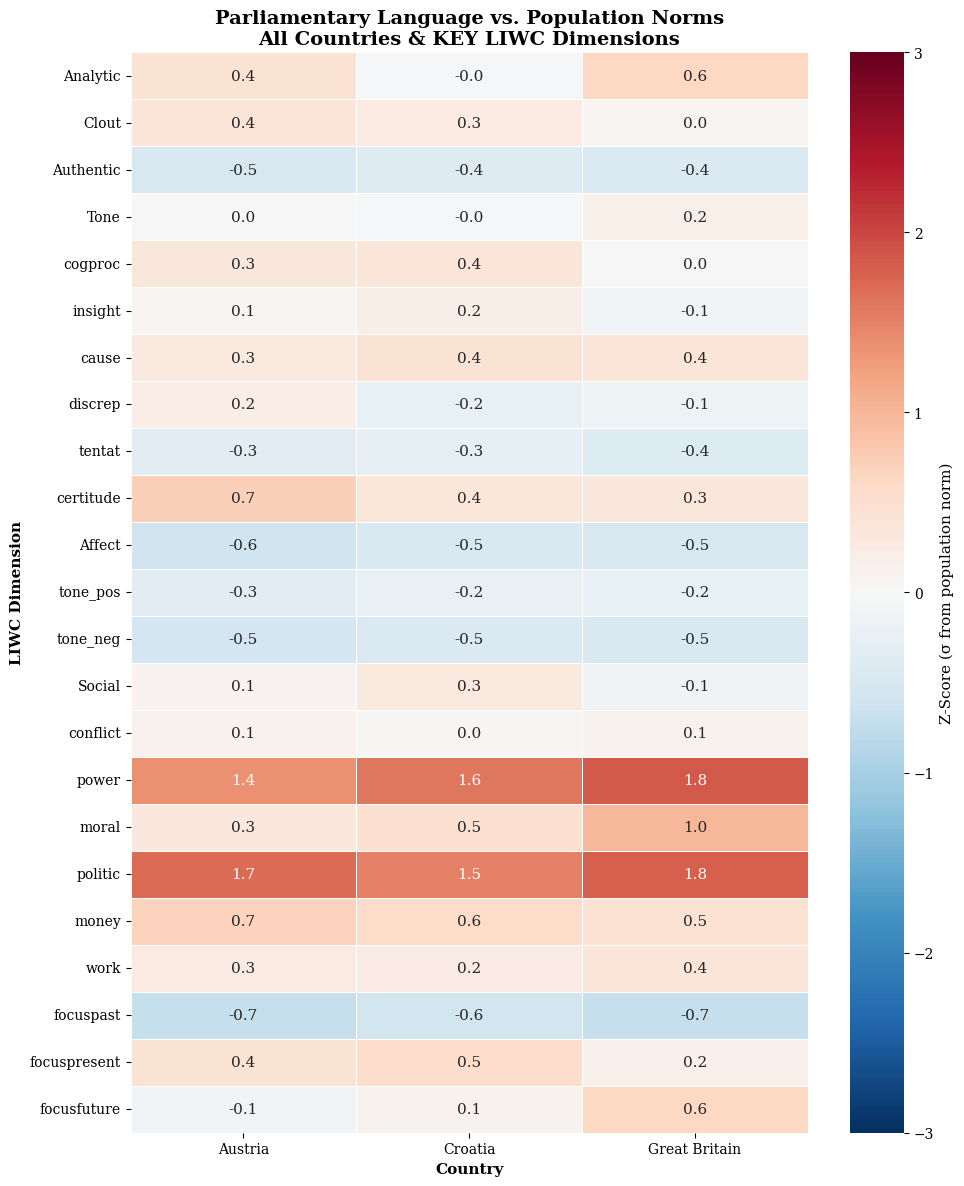


📈 KEY FINDINGS:
Dimensions analyzed: 23
Countries: Austria, Croatia, Great Britain

Strongest deviation: power in Great Britain (1.8σ)

Significant deviations by country (|z| ≥ 1.0):
  Austria: 2 dimensions
  Croatia: 2 dimensions
  Great Britain: 2 dimensions


In [16]:
# Comprehensive heatmap comparing all countries across all KEY LIWC dimensions
def create_comprehensive_heatmap(data, benchmarks, dimensions=None):
    """
    Generate a comprehensive heatmap showing z-score deviations for all countries and KEY LIWC dimensions.
    Z-scores allow proper comparison across different LIWC scales.
    """
    if dimensions is None:
        dimensions = KEY_LIWC_DIMENSIONS

    # Filter dimensions available in both datasets
    available_dims = [d for d in dimensions if d in data.columns and d in benchmarks['Dimension'].values]

    print(f"📊 Comprehensive Country Comparison: {len(available_dims)} LIWC dimensions")
    print("Using z-scores (σ from population norms) for scale-independent comparison")

    # Calculate country means
    country_means = data.groupby('Country')[available_dims].mean()

    # Get benchmark values
    benchmark_lookup = benchmarks.set_index('Dimension')
    benchmark_means = benchmark_lookup.loc[available_dims, 'Mean']
    benchmark_stds = benchmark_lookup.loc[available_dims, 'Std']

    # Calculate z-scores for each country and dimension
    z_scores = (country_means - benchmark_means) / benchmark_stds

    # Plot heatmap
    plt.figure(figsize=(10, max(12, len(available_dims) * 0.4)))
    sns.heatmap(z_scores.T, annot=True, fmt=".1f", cmap="RdBu_r", center=0, 
                cbar_kws={'label': 'Z-Score (σ from population norm)'},
                vmin=-3, vmax=3, linewidths=0.5)
    plt.title("Parliamentary Language vs. Population Norms\nAll Countries & KEY LIWC Dimensions", 
              fontsize=14, fontweight='bold')
    plt.xlabel("Country", fontweight='bold')
    plt.ylabel("LIWC Dimension", fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Summary statistics
    print(f"\n📈 KEY FINDINGS:")
    print(f"Dimensions analyzed: {len(available_dims)}")
    print(f"Countries: {', '.join(z_scores.index)}")
    
    # Identify strongest deviations
    abs_z_scores = z_scores.abs()
    max_deviation = abs_z_scores.max().max()
    max_location = abs_z_scores.stack().idxmax()
    
    print(f"\nStrongest deviation: {max_location[1]} in {max_location[0]} ({z_scores.loc[max_location[0], max_location[1]]:.1f}σ)")
    
    # Count significant deviations by country
    print("\nSignificant deviations by country (|z| ≥ 1.0):")
    for country in z_scores.index:
        strong_deviations = (abs_z_scores.loc[country] >= 1.0).sum()
        print(f"  {country}: {strong_deviations} dimensions")
    
    return z_scores

# Create comprehensive heatmap
z_score_matrix = create_comprehensive_heatmap(LIWC_ALL, LIWC_benchmarks)

## 1. Most Distinctive Parliamentary Language Features

Analyzing 23 of your 23 specified dimensions
📊 Note: All comparisons use z-scores to handle different LIWC scales properly


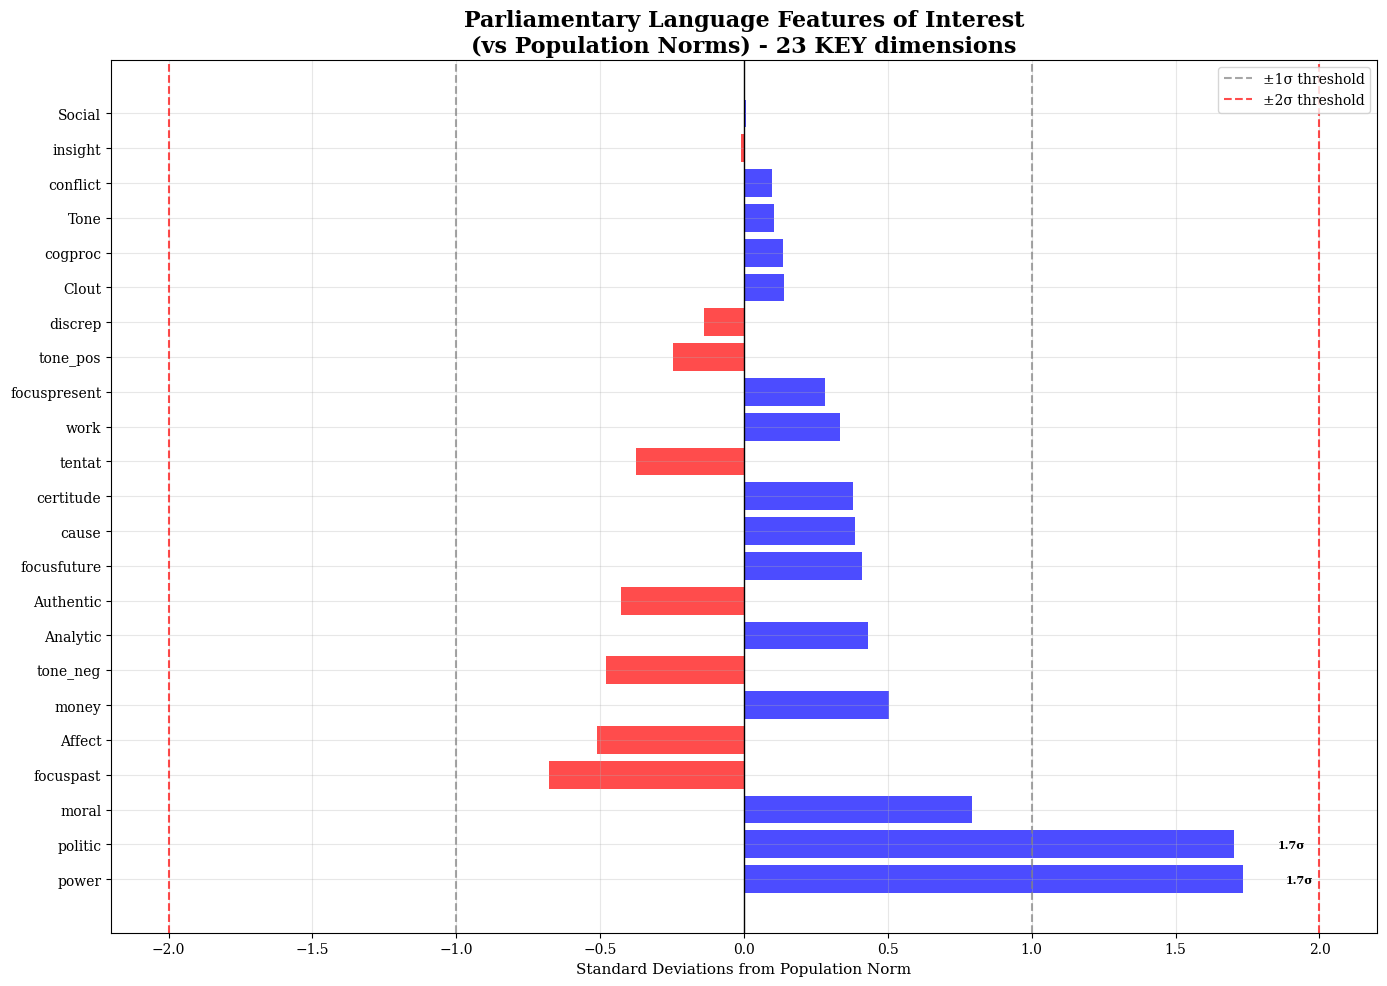


📊 SUMMARY OF YOUR 23 KEY DIMENSIONS:
✅ Available in data: 23
🔍 With population benchmarks: 23
📈 Moderate deviations (1-2σ): 2


In [17]:
# Visualize most distinctive parliamentary language features
def plot_distinctive_features(data, benchmarks, threshold=1.0):
    """
    Plot the most distinctive features of parliamentary language vs population norms
    Focus only on KEY_LIWC_DIMENSIONS - ALWAYS use z-scores for proper comparison
    """
    if benchmarks is None:
        return
    
    # Use ONLY your KEY_LIWC_DIMENSIONS that are available in both datasets
    available_dims = [d for d in KEY_LIWC_DIMENSIONS if d in data.columns and d in benchmarks['Dimension'].values]
    
    print(f"Analyzing {len(available_dims)} of your {len(KEY_LIWC_DIMENSIONS)} specified dimensions")
    print("📊 Note: All comparisons use z-scores to handle different LIWC scales properly")
    
    benchmark_lookup = benchmarks.set_index('Dimension')
    
    # Calculate overall parliamentary deviation from norms
    overall_deviations = []
    
    for dim in available_dims:
        if dim in benchmark_lookup.index:
            benchmark_mean = benchmark_lookup.loc[dim, 'Mean']
            benchmark_std = benchmark_lookup.loc[dim, 'Std']
            parl_mean = data[dim].mean()
            
            z_score = (parl_mean - benchmark_mean) / benchmark_std
            
            overall_deviations.append({
                'Dimension': dim,
                'Parliamentary_Mean': parl_mean,
                'Population_Norm': benchmark_mean,
                'Z_Score': z_score,
                'Abs_Z_Score': abs(z_score),
                'Scale_Type': 'Summary' if dim in ['Analytic', 'Clout', 'Authentic', 'Tone'] else 
                             'Word_Count' if dim in ['WPS', 'BigWords'] else 'Percentage'
            })
    
    deviations_df = pd.DataFrame(overall_deviations)
    
    # Single plot with ALL available dimensions from your KEY_LIWC_DIMENSIONS
    fig, ax = plt.subplots(1, 1, figsize=(14, max(10, len(deviations_df) * 0.4)))
    
    # Show ALL distinctive features from your specified dimensions
    top_deviations = deviations_df.sort_values('Abs_Z_Score', ascending=False)
    
    colors = ['red' if z < 0 else 'blue' for z in top_deviations['Z_Score']]
    bars = ax.barh(top_deviations['Dimension'], top_deviations['Z_Score'], color=colors, alpha=0.7)
    
    ax.axvline(x=0, color='black', linestyle='-', linewidth=1)
    ax.axvline(x=1, color='gray', linestyle='--', alpha=0.7, label='±1σ threshold')
    ax.axvline(x=-1, color='gray', linestyle='--', alpha=0.7)
    ax.axvline(x=2, color='red', linestyle='--', alpha=0.7, label='±2σ threshold')
    ax.axvline(x=-2, color='red', linestyle='--', alpha=0.7)
    
    ax.set_xlabel('Standard Deviations from Population Norm')
    ax.set_title(f'Parliamentary Language Features of Interest\n(vs Population Norms) - {len(top_deviations)} KEY dimensions', fontsize=16, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Add value labels for significant deviations only (|z| >= 1)
    for bar, value in zip(bars, top_deviations['Z_Score']):
        if abs(value) >= 1.0:  # Only label significant deviations
            ax.text(value + (0.15 if value > 0 else -0.15), bar.get_y() + bar.get_height()/2, 
                    f'{value:.1f}σ', va='center', ha='left' if value > 0 else 'right', fontweight='bold', fontsize=8)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary focusing on your dimensions
    print(f"\n📊 SUMMARY OF YOUR {len(KEY_LIWC_DIMENSIONS)} KEY DIMENSIONS:")
    print(f"✅ Available in data: {len(available_dims)}")
    print(f"🔍 With population benchmarks: {len(deviations_df)}")
    
    strong_deviations = deviations_df[deviations_df['Abs_Z_Score'] >= 2]
    moderate_deviations = deviations_df[(deviations_df['Abs_Z_Score'] >= 1) & (deviations_df['Abs_Z_Score'] < 2)]
    
    if len(strong_deviations) > 0:
        print(f"🔥 Strong deviations (≥2σ): {len(strong_deviations)}")
    if len(moderate_deviations) > 0:
        print(f"📈 Moderate deviations (1-2σ): {len(moderate_deviations)}")

# Generate the distinctive features analysis
plot_distinctive_features(LIWC_ALL, LIWC_benchmarks)

Using 6 technocratic features from your KEY dimensions: ['Analytic', 'cogproc', 'insight', 'cause', 'certitude', 'work']


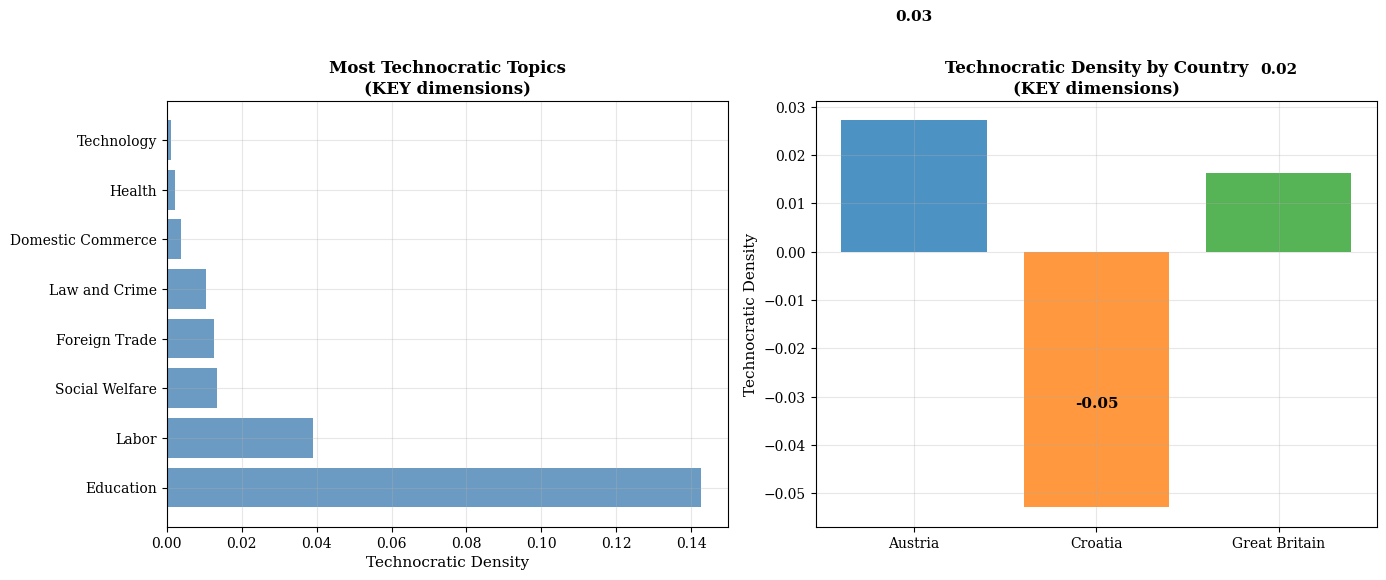

📊 Technocratic Analysis using 6 KEY dimensions
Features used: Analytic, cogproc, insight, cause, certitude, work
Most technical: Education (0.14)
Country ranking: Austria > Great Britain > Croatia


In [18]:
# Focused technocratic density analysis using your KEY dimensions
def analyze_technocratic_density_clean(data, benchmarks):
    """
    Streamlined technocratic density analysis using KEY_LIWC_DIMENSIONS
    """
    # Use cognitive and analytical dimensions from your KEY_LIWC_DIMENSIONS
    techno_features = [
        'Analytic', 'BigWords', 'cogproc', 'insight', 'cause', 'certitude', 
        'tech', 'work'  # Focus on dimensions relevant to technocratic language
    ]
    available_features = [f for f in techno_features if f in data.columns and f in KEY_LIWC_DIMENSIONS]
    
    if len(available_features) < 3:
        print(f"Insufficient technocratic features available. Found: {available_features}")
        return
    
    print(f"Using {len(available_features)} technocratic features from your KEY dimensions: {available_features}")
    
    # Calculate composite index
    techno_data = data[available_features + ['Country', 'Our_Topic']].copy()
    
    # Simple z-score normalization
    for feature in available_features:
        techno_data[f'{feature}_z'] = (techno_data[feature] - techno_data[feature].mean()) / techno_data[feature].std()
    
    techno_data['Techno_Density'] = techno_data[[f'{f}_z' for f in available_features]].mean(axis=1)
    
    # Calculate topic and country means for summary
    topic_means = techno_data.groupby('Our_Topic')['Techno_Density'].mean().nlargest(8)
    country_means = techno_data.groupby('Country')['Techno_Density'].mean()
    
    # Visualization only
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    # Plot 1: Top technocratic topics
    ax1.barh(range(len(topic_means)), topic_means.values, color='steelblue', alpha=0.8)
    ax1.set_yticks(range(len(topic_means)))
    ax1.set_yticklabels([t[:25] + '...' if len(t) > 25 else t for t in topic_means.index])
    ax1.set_xlabel('Technocratic Density')
    ax1.set_title('Most Technocratic Topics\n(KEY dimensions)', fontweight='bold')
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Country comparison
    bars = ax2.bar(country_means.index, country_means.values, 
                   color=['#1f77b4', '#ff7f0e', '#2ca02c'], alpha=0.8)
    ax2.set_ylabel('Technocratic Density')
    ax2.set_title('Technocratic Density by Country\n(KEY dimensions)', fontweight='bold')
    ax2.grid(True, alpha=0.3)
    
    # Add value labels
    for bar, value in zip(bars, country_means.values):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                f'{value:.2f}', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Brief summary
    print(f"📊 Technocratic Analysis using {len(available_features)} KEY dimensions")
    print(f"Features used: {', '.join(available_features)}")
    print(f"Most technical: {topic_means.index[0]} ({topic_means.iloc[0]:.2f})")
    print(f"Country ranking: {' > '.join(country_means.sort_values(ascending=False).index)}")
    
    return techno_data

# Run focused analysis
techno_results = analyze_technocratic_density_clean(LIWC_ALL, LIWC_benchmarks)

Using certainty dimensions from your KEY list: ['certitude', 'tentat']


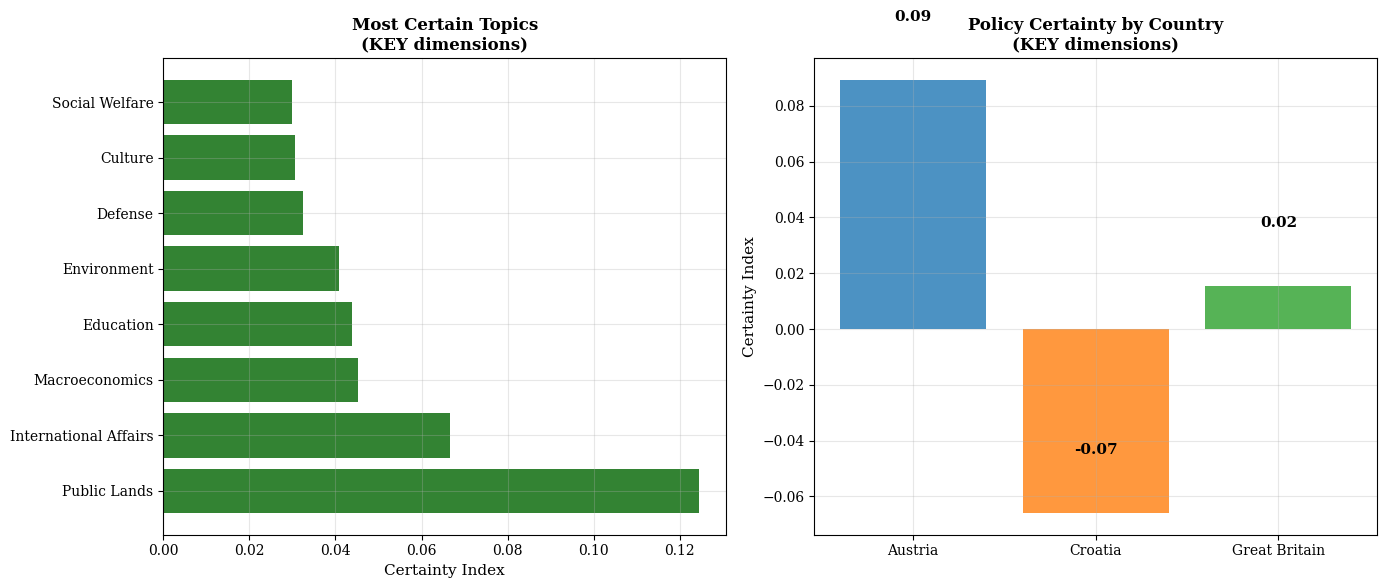

📊 Certainty Analysis using KEY dimensions: ['certitude', 'tentat']
Most certain topic: Public Lands (0.12)
Country certainty: Austria > Great Britain > Croatia


In [19]:
# Focused certainty analysis using your KEY dimensions
def analyze_certainty_clean(data, benchmarks):
    """Certainty vs hedging analysis using KEY_LIWC_DIMENSIONS"""
    
    # Check for certainty-related dimensions from your KEY_LIWC_DIMENSIONS
    certainty_dims = ['certitude', 'tentat']
    available_certainty = [d for d in certainty_dims if d in data.columns and d in KEY_LIWC_DIMENSIONS]
    
    if len(available_certainty) < 2:
        print(f"Missing certainty features from KEY dimensions. Available: {available_certainty}")
        return
    
    print(f"Using certainty dimensions from your KEY list: {available_certainty}")
    
    # Calculate certainty index
    cert_data = data[available_certainty + ['Country', 'Our_Topic']].copy()
    cert_data['Certainty_Index'] = (cert_data['certitude'] - cert_data['certitude'].mean()) / cert_data['certitude'].std() - \
                                   (cert_data['tentat'] - cert_data['tentat'].mean()) / cert_data['tentat'].std()
    
    # Calculate country means for the plot
    country_cert = cert_data.groupby('Country')['Certainty_Index'].mean()
    
    # Visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    # Most certain topics
    topic_cert = cert_data.groupby('Our_Topic')['Certainty_Index'].mean().nlargest(8)
    ax1.barh(range(len(topic_cert)), topic_cert.values, color='darkgreen', alpha=0.8)
    ax1.set_yticks(range(len(topic_cert)))
    ax1.set_yticklabels([t[:25] + '...' if len(t) > 25 else t for t in topic_cert.index])
    ax1.set_xlabel('Certainty Index')
    ax1.set_title('Most Certain Topics\n(KEY dimensions)', fontweight='bold')
    ax1.grid(True, alpha=0.3)
    
    # Country comparison
    bars = ax2.bar(country_cert.index, country_cert.values, 
                   color=['#1f77b4', '#ff7f0e', '#2ca02c'], alpha=0.8)
    ax2.set_ylabel('Certainty Index')
    ax2.set_title('Policy Certainty by Country\n(KEY dimensions)', fontweight='bold')
    ax2.grid(True, alpha=0.3)
    
    # Add value labels
    for bar, value in zip(bars, country_cert.values):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                f'{value:.2f}', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    print(f"📊 Certainty Analysis using KEY dimensions: {available_certainty}")
    print(f"Most certain topic: {topic_cert.index[0]} ({topic_cert.iloc[0]:.2f})")
    print(f"Country certainty: {' > '.join(country_cert.sort_values(ascending=False).index)}")
    
    return cert_data

certainty_results = analyze_certainty_clean(LIWC_ALL, LIWC_benchmarks)

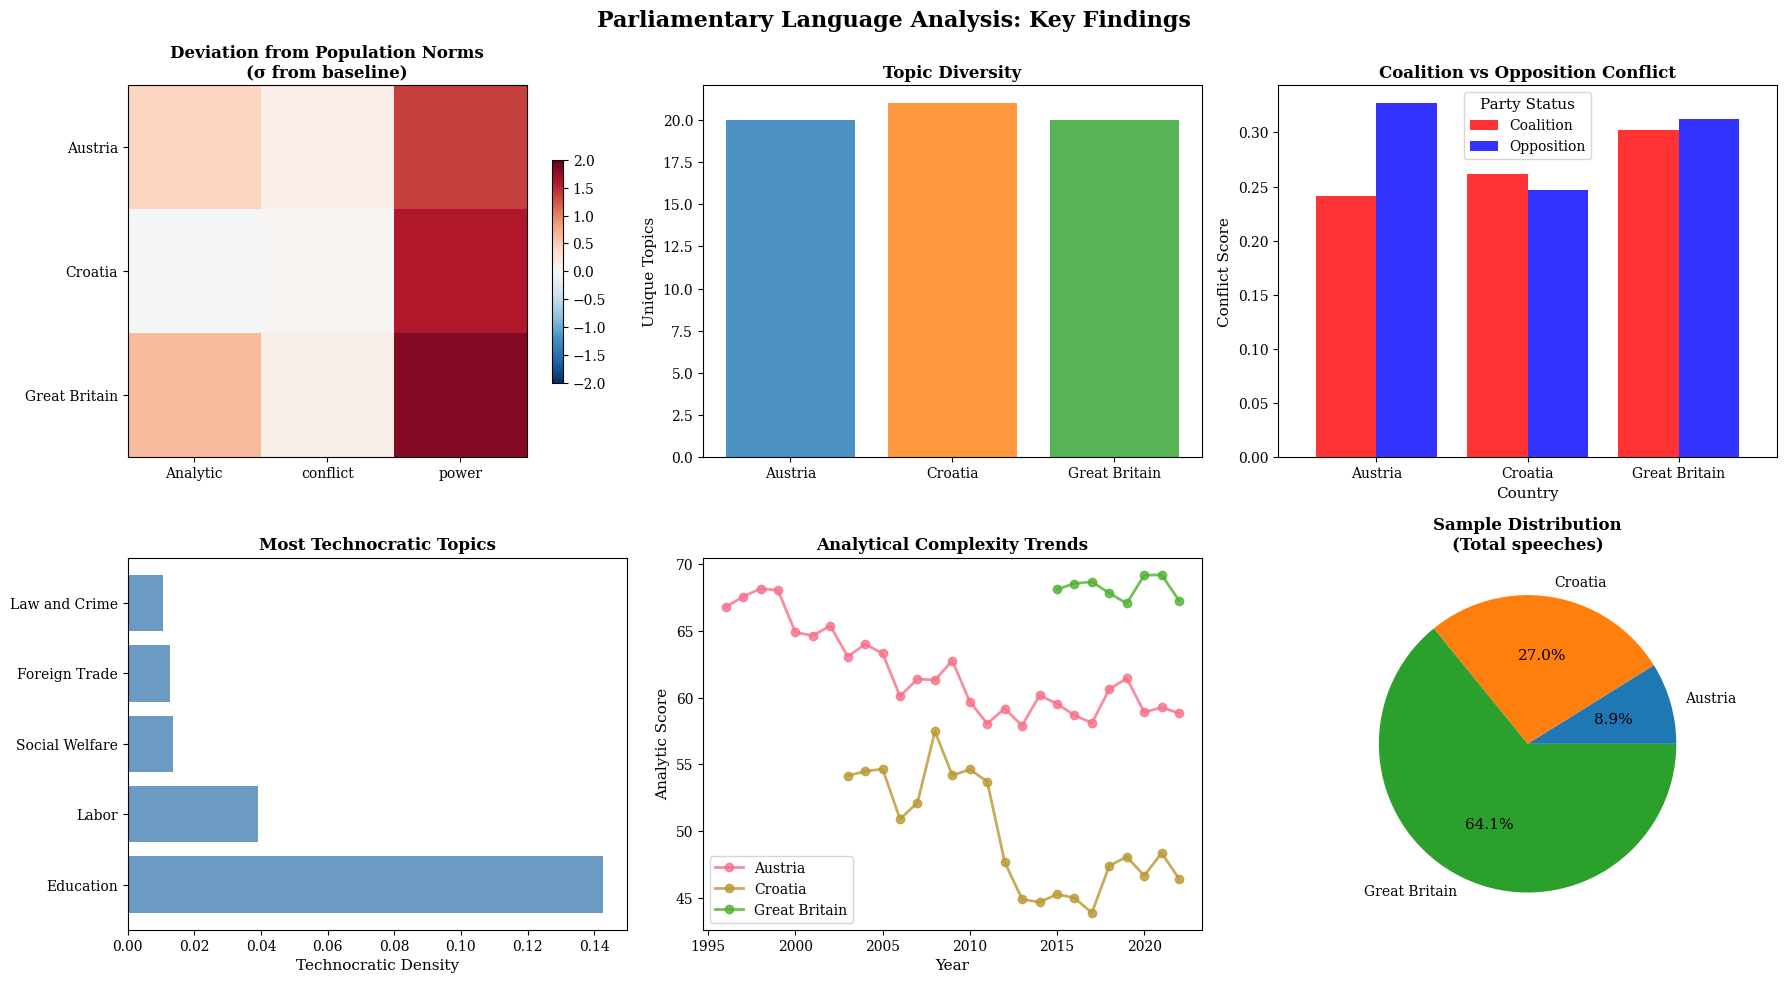

📊 KEY STATISTICS
----------------------------------------
Total speeches analyzed: 819,579
Countries: 3
Topics: 21
Time span: 1996-2022


In [20]:
# Create executive summary dashboard
def create_executive_summary(data, benchmarks):
    """
    Create a concise dashboard of key findings
    """
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle('Parliamentary Language Analysis: Key Findings', fontsize=16, fontweight='bold')
    
    # 1. Country deviation from norms (top 3 dimensions)
    key_dims = ['Analytic', 'conflict', 'power']
    benchmark_lookup = benchmarks.set_index('Dimension')
    
    country_deviations = []
    for country in data['Country'].unique():
        country_data = data[data['Country'] == country]
        for dim in key_dims:
            if dim in benchmark_lookup.index:
                mean_val = country_data[dim].mean()
                norm_mean = benchmark_lookup.loc[dim, 'Mean']
                norm_std = benchmark_lookup.loc[dim, 'Std']
                z_score = (mean_val - norm_mean) / norm_std
                country_deviations.append({'Country': country, 'Dimension': dim, 'Z_Score': z_score})
    
    deviation_df = pd.DataFrame(country_deviations)
    deviation_pivot = deviation_df.pivot(index='Country', columns='Dimension', values='Z_Score')
    
    im = axes[0,0].imshow(deviation_pivot.values, cmap='RdBu_r', aspect='auto', vmin=-2, vmax=2)
    axes[0,0].set_xticks(range(len(key_dims)))
    axes[0,0].set_xticklabels(key_dims)
    axes[0,0].set_yticks(range(len(deviation_pivot.index)))
    axes[0,0].set_yticklabels(deviation_pivot.index)
    axes[0,0].set_title('Deviation from Population Norms\n(σ from baseline)', fontweight='bold')
    plt.colorbar(im, ax=axes[0,0], shrink=0.6)
    
    # 2. Topic diversity by country
    topic_counts = data.groupby('Country')['Our_Topic'].nunique()
    axes[0,1].bar(topic_counts.index, topic_counts.values, color=['#1f77b4', '#ff7f0e', '#2ca02c'], alpha=0.8)
    axes[0,1].set_title('Topic Diversity', fontweight='bold')
    axes[0,1].set_ylabel('Unique Topics')
    
    # 3. Coalition vs Opposition conflict (where available)
    if 'Party_status' in data.columns:
        party_data = data[data['Party_status'].isin(['Coalition', 'Opposition'])]
        party_conflict = party_data.groupby(['Country', 'Party_status'])['conflict'].mean().unstack()
        if not party_conflict.empty:
            party_conflict.plot(kind='bar', ax=axes[0,2], color=['red', 'blue'], alpha=0.8, width=0.8)
            axes[0,2].set_title('Coalition vs Opposition Conflict', fontweight='bold')
            axes[0,2].set_ylabel('Conflict Score')
            axes[0,2].legend(title='Party Status')
            axes[0,2].tick_params(axis='x', rotation=0)
    
    # 4. Most distinctive topics (top 5)
    if 'techno_results' in globals() and techno_results is not None:
        top_techno = techno_results.groupby('Our_Topic')['Techno_Density'].mean().nlargest(5)
        axes[1,0].barh(range(len(top_techno)), top_techno.values, color='steelblue', alpha=0.8)
        axes[1,0].set_yticks(range(len(top_techno)))
        axes[1,0].set_yticklabels([t[:20] + '...' if len(t) > 20 else t for t in top_techno.index])
        axes[1,0].set_title('Most Technocratic Topics', fontweight='bold')
        axes[1,0].set_xlabel('Technocratic Density')
    
    # 5. Temporal trend (if available)
    if 'Year' in data.columns and data['Year'].notna().sum() > 50:
        yearly_analytic = data.groupby(['Year', 'Country'])['Analytic'].mean().reset_index()
        for country in yearly_analytic['Country'].unique():
            country_data = yearly_analytic[yearly_analytic['Country'] == country]
            if len(country_data) > 3:
                axes[1,1].plot(country_data['Year'], country_data['Analytic'], 
                              marker='o', linewidth=2, label=country, alpha=0.8)
        axes[1,1].set_title('Analytical Complexity Trends', fontweight='bold')
        axes[1,1].set_xlabel('Year')
        axes[1,1].set_ylabel('Analytic Score')
        axes[1,1].legend()
    else:
        axes[1,1].text(0.5, 0.5, 'Insufficient\nTemporal Data', ha='center', va='center', 
                      transform=axes[1,1].transAxes, fontsize=14)
        axes[1,1].set_title('Temporal Analysis', fontweight='bold')
    
    # 6. Sample sizes
    sample_sizes = data.groupby('Country').size()
    axes[1,2].pie(sample_sizes.values, labels=sample_sizes.index, autopct='%1.1f%%', 
                  colors=['#1f77b4', '#ff7f0e', '#2ca02c'])
    axes[1,2].set_title('Sample Distribution\n(Total speeches)', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Print key statistics
    print("📊 KEY STATISTICS")
    print("-" * 40)
    total_speeches = len(data)
    print(f"Total speeches analyzed: {total_speeches:,}")
    print(f"Countries: {len(data['Country'].unique())}")
    print(f"Topics: {len(data['Our_Topic'].unique())}")
    if 'Year' in data.columns:
        year_range = data['Year'].dropna()
        if len(year_range) > 0:
            print(f"Time span: {year_range.min():.0f}-{year_range.max():.0f}")

# Create executive summary
create_executive_summary(LIWC_ALL, LIWC_benchmarks)

## 2. Coalition vs Opposition Dynamics

## 3. Cross-Country Topic Analysis

Coalition vs Opposition Analysis:
Total speeches in analysis: 343,139
Great Britain: Coalition=13,793, Opposition=128,262
Great Britain: Coalition=13,793, Opposition=128,262
Austria: Coalition=16,877, Opposition=11,258
Austria: Coalition=16,877, Opposition=11,258
Croatia: Coalition=108,281, Opposition=64,668
Croatia: Coalition=108,281, Opposition=64,668


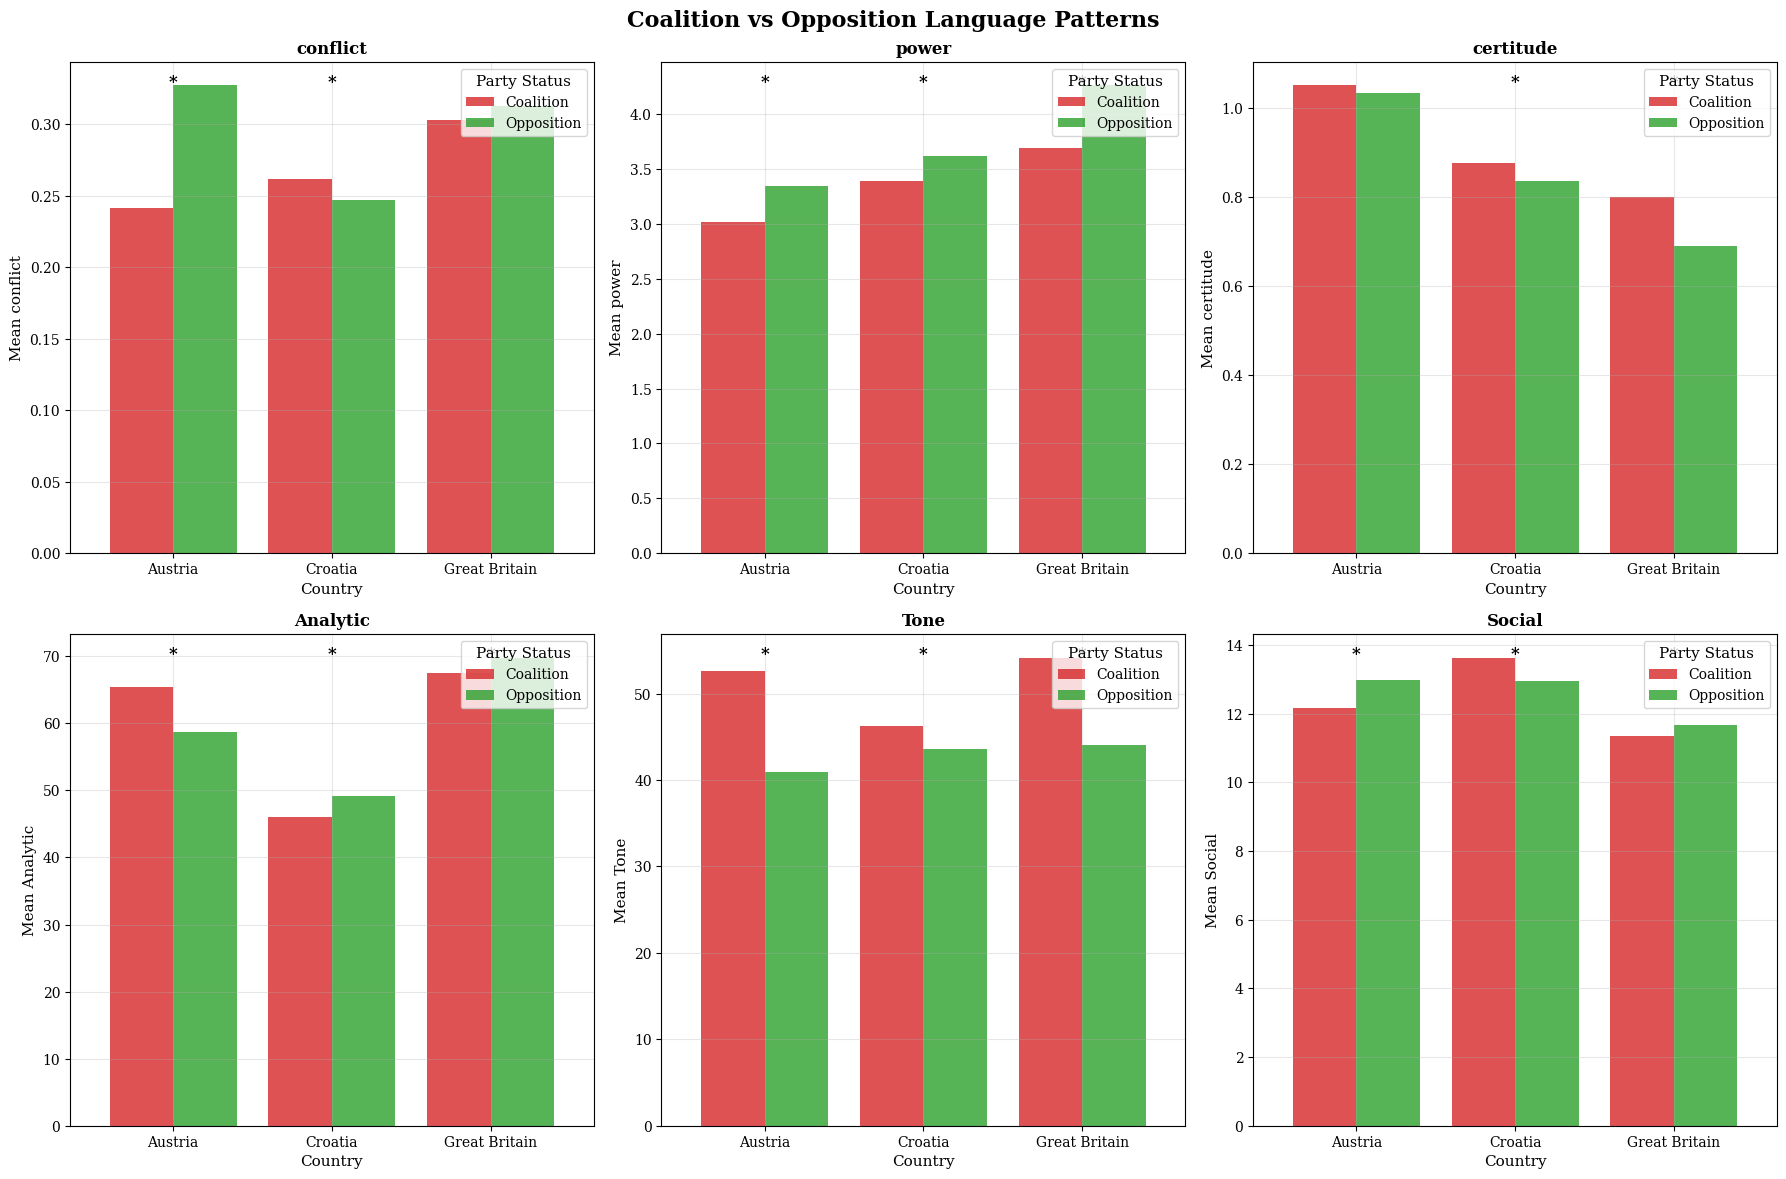


COALITION vs OPPOSITION STATISTICAL ANALYSIS

conflict:
  Great Britain: Coal=0.30, Opp=0.31, d=-0.01, p=0.381 
  Great Britain: Coal=0.30, Opp=0.31, d=-0.01, p=0.381 
  Austria: Coal=0.24, Opp=0.33, d=-0.18, p=0.000 ***
  Austria: Coal=0.24, Opp=0.33, d=-0.18, p=0.000 ***
  Croatia: Coal=0.26, Opp=0.25, d=0.02, p=0.000 ***

power:
  Croatia: Coal=0.26, Opp=0.25, d=0.02, p=0.000 ***

power:
  Great Britain: Coal=3.69, Opp=4.26, d=-0.11, p=0.000 ***
  Great Britain: Coal=3.69, Opp=4.26, d=-0.11, p=0.000 ***
  Austria: Coal=3.02, Opp=3.34, d=-0.13, p=0.000 ***
  Austria: Coal=3.02, Opp=3.34, d=-0.13, p=0.000 ***
  Croatia: Coal=3.39, Opp=3.62, d=-0.07, p=0.000 ***

certitude:
  Croatia: Coal=3.39, Opp=3.62, d=-0.07, p=0.000 ***

certitude:
  Great Britain: Coal=0.80, Opp=0.69, d=0.07, p=0.000 ***
  Great Britain: Coal=0.80, Opp=0.69, d=0.07, p=0.000 ***
  Austria: Coal=1.05, Opp=1.03, d=0.01, p=0.430 
  Austria: Coal=1.05, Opp=1.03, d=0.01, p=0.430 
  Croatia: Coal=0.88, Opp=0.84, d=0.0

In [21]:
# Analyze coalition vs opposition patterns
coalition_opposition_data = LIWC_ALL[LIWC_ALL['Party_status'].isin(['Coalition', 'Opposition'])].copy()

print(f"Coalition vs Opposition Analysis:")
print(f"Total speeches in analysis: {len(coalition_opposition_data):,}")
for country in coalition_opposition_data['Country'].unique():
    country_data = coalition_opposition_data[coalition_opposition_data['Country'] == country]
    coal_count = len(country_data[country_data['Party_status'] == 'Coalition'])
    opp_count = len(country_data[country_data['Party_status'] == 'Opposition'])
    print(f"{country}: Coalition={coal_count:,}, Opposition={opp_count:,}")

# Create comprehensive visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Coalition vs Opposition Language Patterns', fontsize=16, fontweight='bold')
    
# Use dimensions from KEY_LIWC_DIMENSIONS that are relevant for political analysis
key_dims = ['conflict', 'power', 'certitude', 'Analytic', 'Tone', 'Social']
    
for idx, dim in enumerate(key_dims):
    ax = axes[idx//3, idx%3]
        
    # Create interaction plot: Country x Party Status
    interaction_data = coalition_opposition_data.groupby(['Country', 'Party_status'])[dim].mean().unstack()
        
    if not interaction_data.empty:
        interaction_data.plot(kind='bar', ax=ax, color=['#d62728', '#2ca02c'], 
                               width=0.8, alpha=0.8)
        ax.set_title(f'{dim}', fontweight='bold')
        ax.set_ylabel(f'Mean {dim}')
        ax.set_xlabel('Country')
        ax.legend(title='Party Status', loc='upper right')
        ax.tick_params(axis='x', rotation=0)
        ax.grid(True, alpha=0.3)
            
        # Add significance indicators
        for i, country in enumerate(interaction_data.index):
            country_data = coalition_opposition_data[coalition_opposition_data['Country'] == country]
            coalition = country_data[country_data['Party_status'] == 'Coalition'][dim].dropna()
            opposition = country_data[country_data['Party_status'] == 'Opposition'][dim].dropna()
                
            if len(coalition) > 5 and len(opposition) > 5:
                _, p_val = ttest_ind(coalition, opposition, equal_var=False)
                if p_val < 0.05:
                    ax.text(i, ax.get_ylim()[1] * 0.95, '*', ha='center', fontsize=12, fontweight='bold')
    
plt.tight_layout()
plt.show()

# Detailed statistical analysis
print("\n" + "="*60)
print("COALITION vs OPPOSITION STATISTICAL ANALYSIS")
print("="*60)
    
for dim in key_dims:
    if dim in LIWC_ALL.columns:
        print(f"\n{dim}:")
        for country in coalition_opposition_data['Country'].unique():
            country_data = coalition_opposition_data[coalition_opposition_data['Country'] == country]
            coalition = country_data[country_data['Party_status'] == 'Coalition'][dim].dropna()
            opposition = country_data[country_data['Party_status'] == 'Opposition'][dim].dropna()
                
            if len(coalition) > 5 and len(opposition) > 5:
                stat, p_val = ttest_ind(coalition, opposition, equal_var=False)
                effect_size = (coalition.mean() - opposition.mean()) / np.sqrt(((coalition.std()**2) + (opposition.std()**2)) / 2)
                significance = "***" if p_val < 0.001 else "**" if p_val < 0.01 else "*" if p_val < 0.05 else ""
                print(f"  {country}: Coal={coalition.mean():.2f}, Opp={opposition.mean():.2f}, d={effect_size:.2f}, p={p_val:.3f} {significance}")
            else:
                print(f"  {country}: Insufficient data (Coal: {len(coalition)}, Opp: {len(opposition)})")

## 4. Temporal Evolution Analysis

Temporal Analysis Coverage:
Year range: 1996-2022
📊 Note: Using z-scores normalized to population norms for scale consistency
📊 Showing max 3 dimensions per plot for clarity


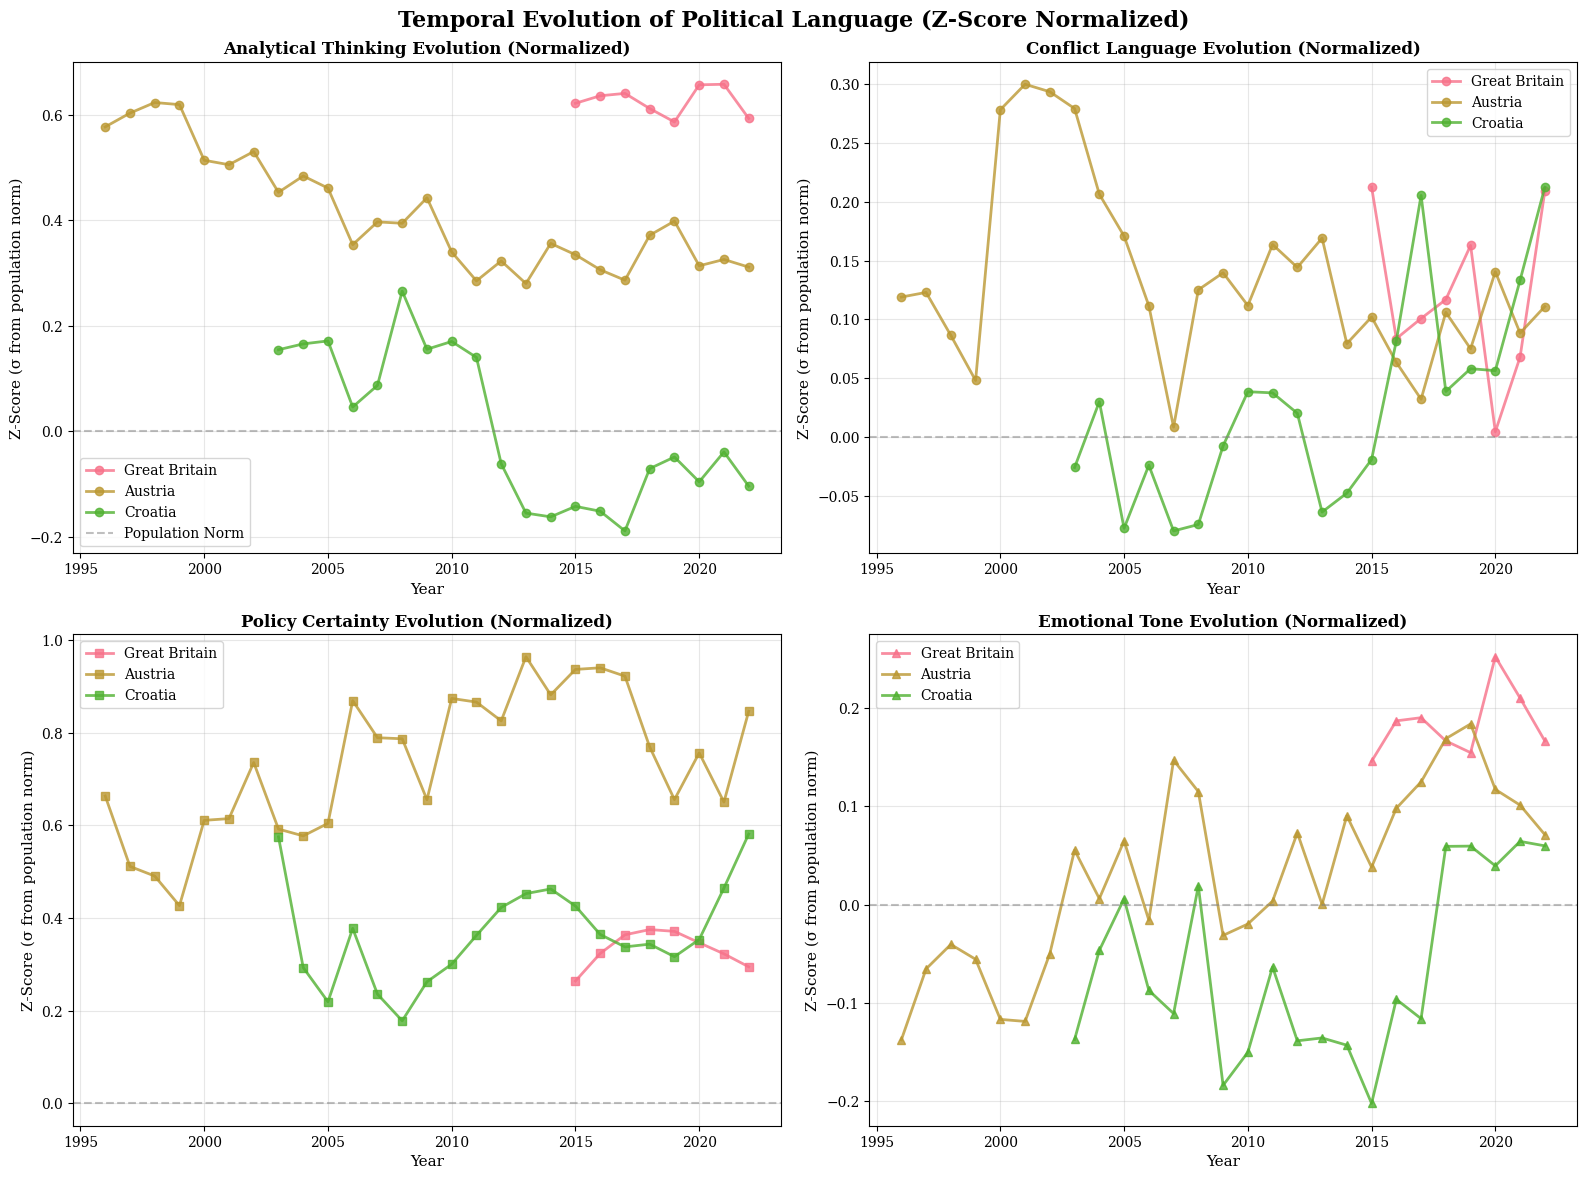


TEMPORAL TREND ANALYSIS
Analytic: decreasing trend, r=-0.219, p=0.274 
Tone: increasing trend, r=0.704, p=0.000 ***
conflict: decreasing trend, r=-0.194, p=0.332 
certitude: decreasing trend, r=-0.551, p=0.003 **


In [22]:
# Temporal analysis - ALWAYS use z-scores for mixed-scale comparisons
if 'Date' in LIWC_ALL.columns and LIWC_ALL['Year'].notna().sum() > 100:
    temporal_data = LIWC_ALL[LIWC_ALL['Year'].notna()].copy()
    year_counts = temporal_data['Year'].value_counts()
    sufficient_years = year_counts[year_counts >= 20].index
    temporal_data = temporal_data[temporal_data['Year'].isin(sufficient_years)]
    
    print(f"Temporal Analysis Coverage:")
    print(f"Year range: {temporal_data['Year'].min():.0f}-{temporal_data['Year'].max():.0f}")
    print("📊 Note: Using z-scores normalized to population norms for scale consistency")
    print("📊 Showing max 3 dimensions per plot for clarity")
    
    # Create z-score normalized data for temporal analysis
    benchmark_lookup = LIWC_benchmarks.set_index('Dimension')
    
    # Normalize all available dimensions to z-scores
    temporal_z_data = temporal_data.copy()
    normalized_dims = []
    
    for dim in KEY_LIWC_DIMENSIONS:
        if dim in temporal_data.columns and dim in benchmark_lookup.index:
            benchmark_mean = benchmark_lookup.loc[dim, 'Mean']
            benchmark_std = benchmark_lookup.loc[dim, 'Std']
            temporal_z_data[f'{dim}_z'] = (temporal_data[dim] - benchmark_mean) / benchmark_std
            normalized_dims.append(f'{dim}_z')
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Temporal Evolution of Political Language (Z-Score Normalized)', fontsize=16, fontweight='bold')
    
    # Plot 1: Linguistic complexity trends - SIMPLIFIED to 1 dimension
    complexity_dims_z = [d for d in normalized_dims if 'Analytic_z' in d]
    if complexity_dims_z:
        yearly_complexity = temporal_z_data.groupby(['Year', 'Country'])[complexity_dims_z[0]].mean().reset_index()
        
        for country in temporal_data['Country'].unique():
            country_data = yearly_complexity[yearly_complexity['Country'] == country]
            if len(country_data) > 3:
                axes[0,0].plot(country_data['Year'], country_data[complexity_dims_z[0]], 
                              marker='o', linewidth=2, label=country, alpha=0.8)
    
    axes[0,0].axhline(y=0, color='gray', linestyle='--', alpha=0.5, label='Population Norm')
    axes[0,0].set_title('Analytical Thinking Evolution (Normalized)', fontweight='bold')
    axes[0,0].set_xlabel('Year')
    axes[0,0].set_ylabel('Z-Score (σ from population norm)')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)
    
    # Plot 2: Conflict trends - SIMPLIFIED to 1 dimension
    conflict_dim_z = [d for d in normalized_dims if 'conflict_z' in d]
    if conflict_dim_z:
        yearly_conflict = temporal_z_data.groupby(['Year', 'Country'])[conflict_dim_z[0]].mean().reset_index()
        
        for country in temporal_data['Country'].unique():
            country_data = yearly_conflict[yearly_conflict['Country'] == country]
            if len(country_data) > 3:
                axes[0,1].plot(country_data['Year'], country_data[conflict_dim_z[0]], 
                              marker='o', linewidth=2, label=country, alpha=0.8)
    
    axes[0,1].axhline(y=0, color='gray', linestyle='--', alpha=0.5)
    axes[0,1].set_title('Conflict Language Evolution (Normalized)', fontweight='bold')
    axes[0,1].set_xlabel('Year')
    axes[0,1].set_ylabel('Z-Score (σ from population norm)')
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)
    
    # Plot 3: Certainty trends - SIMPLIFIED to 1 dimension
    certainty_dim_z = [d for d in normalized_dims if 'certitude_z' in d]
    if certainty_dim_z:
        yearly_certainty = temporal_z_data.groupby(['Year', 'Country'])[certainty_dim_z[0]].mean().reset_index()
        
        for country in temporal_data['Country'].unique():
            country_data = yearly_certainty[yearly_certainty['Country'] == country]
            if len(country_data) > 3:
                axes[1,0].plot(country_data['Year'], country_data[certainty_dim_z[0]], 
                              marker='s', linewidth=2, label=country, alpha=0.8)
        
        axes[1,0].axhline(y=0, color='gray', linestyle='--', alpha=0.5)
        axes[1,0].set_title('Policy Certainty Evolution (Normalized)', fontweight='bold')
        axes[1,0].set_xlabel('Year')
        axes[1,0].set_ylabel('Z-Score (σ from population norm)')
        axes[1,0].legend()
        axes[1,0].grid(True, alpha=0.3)
    
    # Plot 4: Tone trends - SIMPLIFIED to 1 dimension
    tone_dim_z = [d for d in normalized_dims if 'Tone_z' in d]
    if tone_dim_z:
        yearly_tone = temporal_z_data.groupby(['Year', 'Country'])[tone_dim_z[0]].mean().reset_index()
        
        for country in temporal_data['Country'].unique():
            country_data = yearly_tone[yearly_tone['Country'] == country]
            if len(country_data) > 3:
                axes[1,1].plot(country_data['Year'], country_data[tone_dim_z[0]], 
                              marker='^', linewidth=2, label=country, alpha=0.8)
        
        axes[1,1].axhline(y=0, color='gray', linestyle='--', alpha=0.5)
        axes[1,1].set_title('Emotional Tone Evolution (Normalized)', fontweight='bold')
        axes[1,1].set_xlabel('Year')
        axes[1,1].set_ylabel('Z-Score (σ from population norm)')
        axes[1,1].legend()
        axes[1,1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Statistical trend analysis
    print("\n" + "="*60)
    print("TEMPORAL TREND ANALYSIS")
    print("="*60)
    
    from scipy.stats import pearsonr
    
    trend_dims = [d for d in ['Analytic', 'Tone', 'conflict', 'certitude'] if d in temporal_data.columns]
    for dim in trend_dims:
        yearly_means = temporal_data.groupby('Year')[dim].mean()
        if len(yearly_means) > 5:
            corr, p_val = pearsonr(yearly_means.index, yearly_means.values)
            trend_direction = "increasing" if corr > 0 else "decreasing"
            significance = "***" if p_val < 0.001 else "**" if p_val < 0.01 else "*" if p_val < 0.05 else ""
            print(f"{dim}: {trend_direction} trend, r={corr:.3f}, p={p_val:.3f} {significance}")

else:
    print("Insufficient temporal data for trend analysis")

## 5. Political Orientation Analysis (Left-Right Spectrum)

Political Orientation Analysis:
Total speeches: 738,747
Analyzing 11 orientation categories with ≥2000 speeches each
Analyzing 11 orientation categories with ≥2000 speeches each


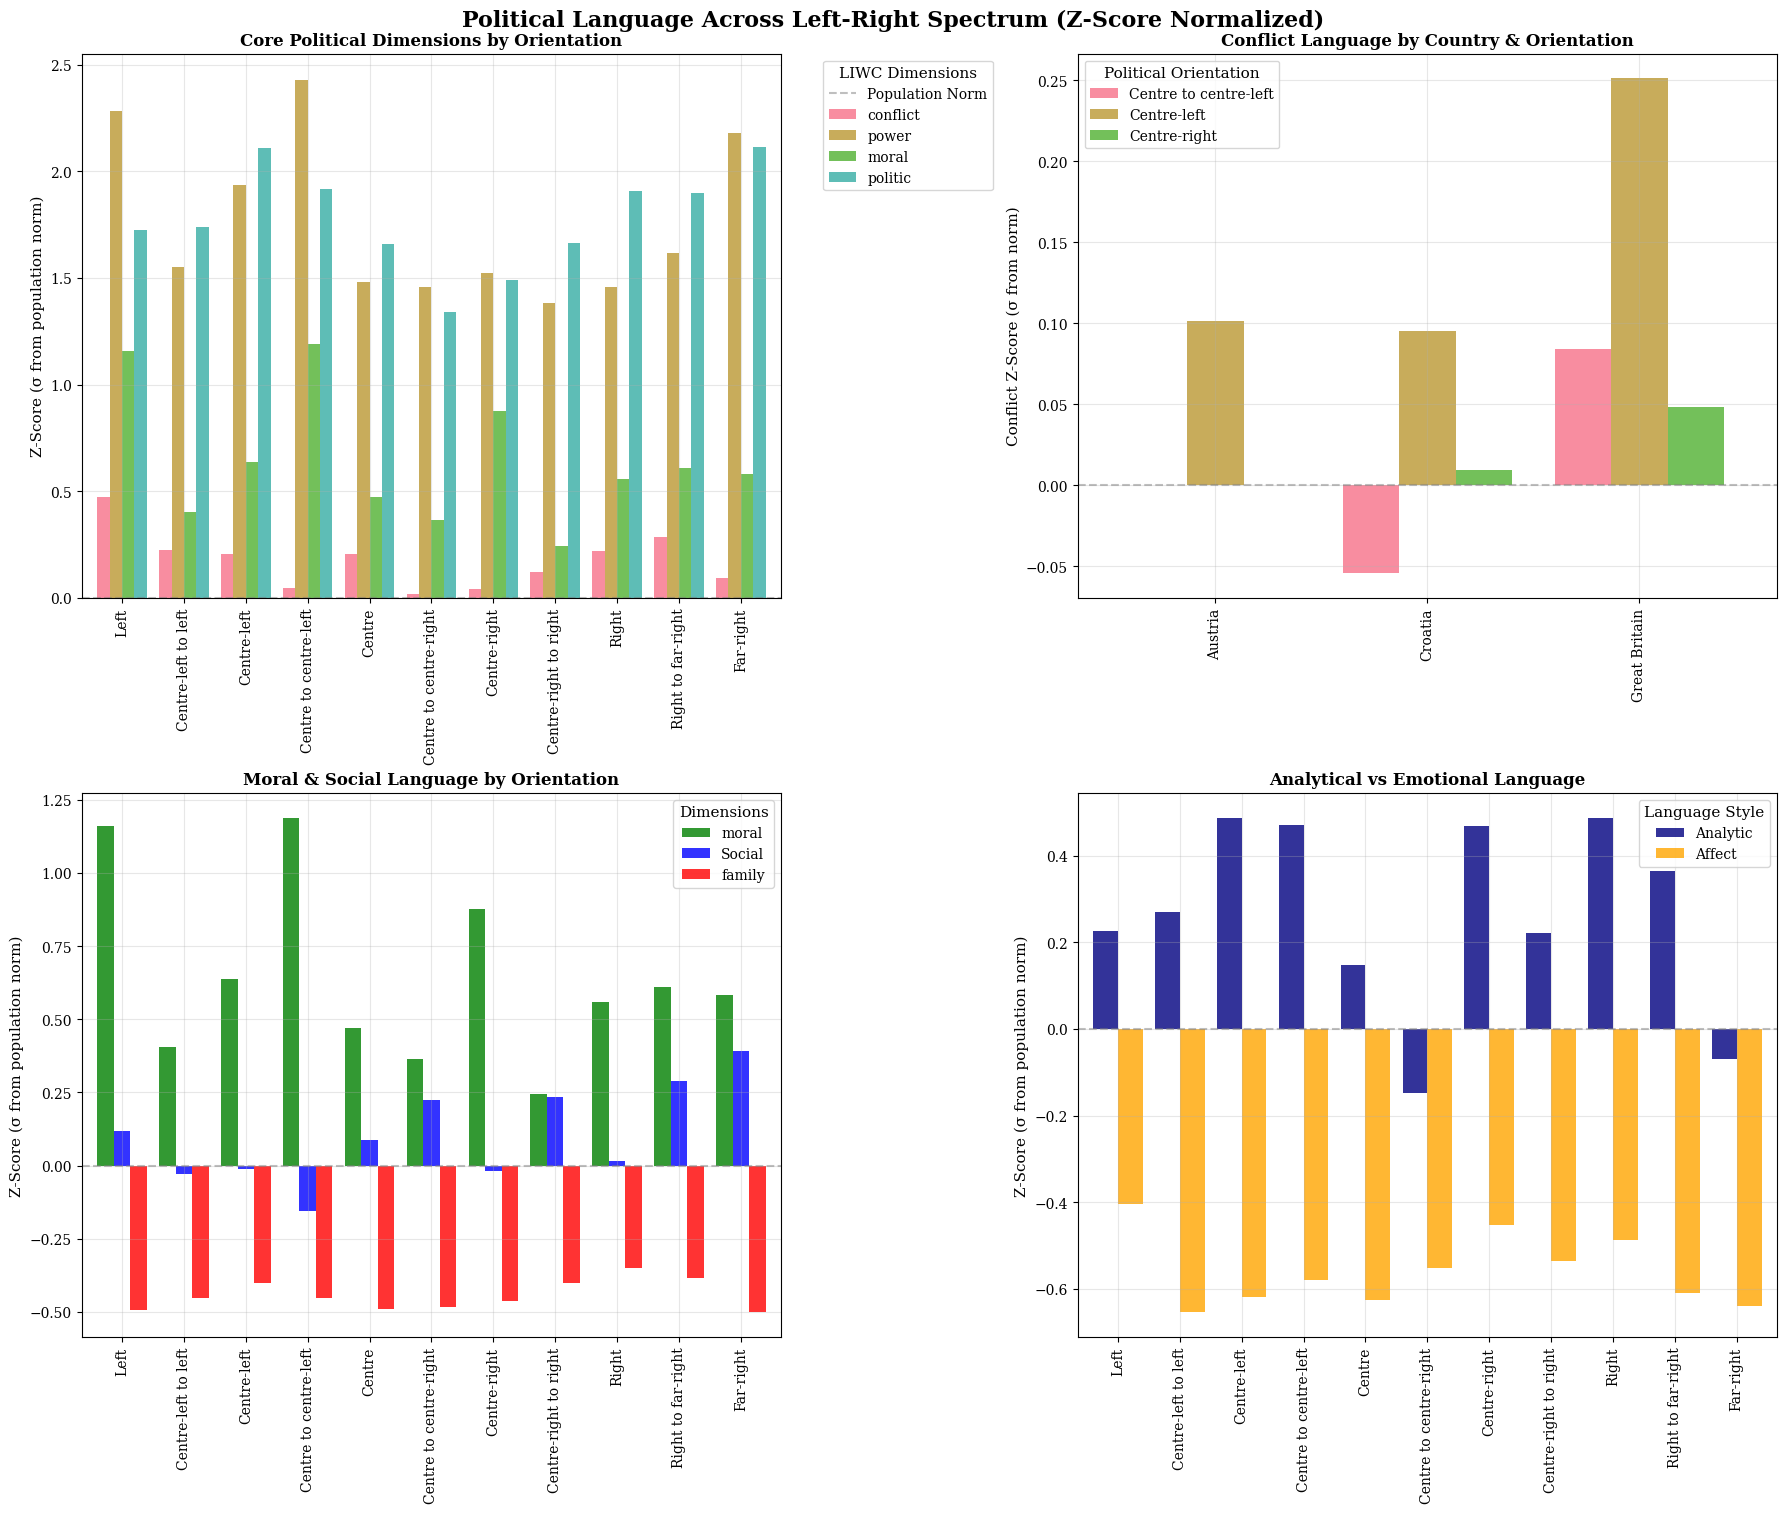


KEY POLITICAL ORIENTATION DIFFERENCES FOR PAPER

CONFLICT:

CONFLICT:
  Left vs Right: d=0.06, p=0.005 *
  Left vs Right: d=0.06, p=0.005 *
  Centre-left vs Centre-right: d=0.04, p=0.000 *
  Centre-left vs Centre-right: d=0.04, p=0.000 *
  Centre-left to left vs Centre-right to right: d=0.06, p=0.000 *

POWER:
  Centre-left to left vs Centre-right to right: d=0.06, p=0.000 *

POWER:
  Left vs Right: d=0.26, p=0.000 *
  Left vs Right: d=0.26, p=0.000 *
  Centre-left vs Centre-right: d=0.13, p=0.000 *
  Centre-left vs Centre-right: d=0.13, p=0.000 *
  Centre-left to left vs Centre-right to right: d=0.08, p=0.000 *

MORAL:
  Centre-left to left vs Centre-right to right: d=0.08, p=0.000 *

MORAL:
  Left vs Right: d=0.18, p=0.000 *
  Left vs Right: d=0.18, p=0.000 *
  Centre-left vs Centre-right: d=-0.06, p=0.000 *
  Centre-left vs Centre-right: d=-0.06, p=0.000 *
  Centre-left to left vs Centre-right to right: d=0.07, p=0.000 *

MOST IMPORTANT FINDINGS FOR PAPER:
• Power: Left shows highe

In [23]:
# Political orientation analysis - USE Z-SCORES for mixed scales
# Filter out rows with "-" or semicolon in Party_orientation
orientation_data = LIWC_ALL[(LIWC_ALL['Party_orientation'].notna()) & 
                           (LIWC_ALL['Party_orientation'] != '-') &
                           (~LIWC_ALL['Party_orientation'].str.contains(';', na=False))].copy()

print(f"Political Orientation Analysis:")
print(f"Total speeches: {len(orientation_data):,}")

# Define political spectrum order from left to right
orientation_order = [
    'Left',
    'Centre-left to left',
    'Centre-left',
    'Centre to centre-left',
    'Centre',
    'Centre to centre-right',
    'Centre-right',
    'Centre-right to right',
    'Right',
    'Right to far-right',
    'Far-right'
]

# Filter to orientations with significant sample sizes (≥2000 speeches)
orientation_counts = orientation_data['Party_orientation'].value_counts()
significant_orientations = orientation_counts[orientation_counts >= 2000].index
available_orientations = [o for o in orientation_order 
                         if o in orientation_data['Party_orientation'].unique() 
                         and o in significant_orientations]

print(f"Analyzing {len(available_orientations)} orientation categories with ≥2000 speeches each")

# Create z-score normalized data
benchmark_lookup = LIWC_benchmarks.set_index('Dimension')
orientation_z_data = orientation_data.copy()

# Normalize political dimensions to z-scores
political_dims = ['conflict', 'power', 'moral', 'politic', 'Social', 'certitude', 'Analytic']
political_dims = [d for d in political_dims if d in orientation_data.columns]

for dim in political_dims:
    benchmark_mean = benchmark_lookup.loc[dim, 'Mean']
    benchmark_std = benchmark_lookup.loc[dim, 'Std']
    orientation_z_data[f'{dim}_z'] = (orientation_data[dim] - benchmark_mean) / benchmark_std

political_dims_z = [f'{d}_z' for d in political_dims]

# Create visualization
fig, axes = plt.subplots(2, 2, figsize=(18, 16))  # Increased height for better label visibility
fig.suptitle('Political Language Across Left-Right Spectrum (Z-Score Normalized)', fontsize=16, fontweight='bold')

# Plot 1: Key political dimensions by orientation (z-normalized)
filtered_data = orientation_z_data[orientation_z_data['Party_orientation'].isin(available_orientations)]
orientation_means = filtered_data.groupby('Party_orientation')[political_dims_z[:4]].mean()
orientation_means = orientation_means.reindex(available_orientations)  # Apply ordered index
orientation_means.columns = [col.replace('_z', '') for col in orientation_means.columns]

ax = axes[0,0]
orientation_means.plot(kind='bar', ax=ax, width=0.8, alpha=0.8)
ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5, label='Population Norm')
ax.set_title('Core Political Dimensions by Orientation', fontweight='bold')
ax.set_ylabel('Z-Score (σ from population norm)')
ax.set_xlabel('')  # Remove x-label as it's redundant
ax.legend(title='LIWC Dimensions', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.tick_params(axis='x', rotation=90)  # Vertical labels for readability
ax.grid(True, alpha=0.3)

# Plot 2: Country-specific orientation patterns (z-normalized)
# Get top 3 orientations for cleaner visualization
top_orientations = orientation_counts.head(3).index
filtered_orient_data = orientation_z_data[orientation_z_data['Party_orientation'].isin(top_orientations)]
country_orientation = filtered_orient_data.groupby(['Country', 'Party_orientation'])['conflict_z'].mean().unstack()

ax = axes[0,1]
country_orientation.plot(kind='bar', ax=ax, width=0.8, alpha=0.8)
ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
ax.set_title('Conflict Language by Country & Orientation', fontweight='bold')
ax.set_ylabel('Conflict Z-Score (σ from norm)')
ax.set_xlabel('')
ax.legend(title='Political Orientation', loc='best')
ax.grid(True, alpha=0.3)

# Plot 3: Moral and social language (z-normalized)
moral_dims_original = [d for d in ['moral', 'Social', 'family'] if d in orientation_data.columns]
moral_dims_z = [f'{d}_z' for d in moral_dims_original]

# Ensure z-score columns exist for moral dimensions
for dim in moral_dims_original:
    if f'{dim}_z' not in orientation_z_data.columns:
        benchmark_mean = benchmark_lookup.loc[dim, 'Mean']
        benchmark_std = benchmark_lookup.loc[dim, 'Std']
        orientation_z_data[f'{dim}_z'] = (orientation_data[dim] - benchmark_mean) / benchmark_std

# Use top orientations by frequency for cleaner visualization
moral_orientation = orientation_z_data.groupby('Party_orientation')[moral_dims_z].mean().reindex(available_orientations)
moral_orientation.columns = [col.replace('_z', '') for col in moral_orientation.columns]

ax = axes[1,0]
moral_orientation.plot(kind='bar', ax=ax, width=0.8, alpha=0.8, color=['green', 'blue', 'red'])
ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
ax.set_title('Moral & Social Language by Orientation', fontweight='bold')
ax.set_ylabel('Z-Score (σ from population norm)')
ax.set_xlabel('')
ax.legend(title='Dimensions')
ax.tick_params(axis='x', rotation=90)
ax.grid(True, alpha=0.3)

# Plot 4: Analytical vs emotional language
analytical_emotional_dims = ['Analytic', 'Affect']
analytical_emotional_z = []

for dim in analytical_emotional_dims:
    if f'{dim}_z' not in orientation_z_data.columns:
        benchmark_mean = benchmark_lookup.loc[dim, 'Mean']
        benchmark_std = benchmark_lookup.loc[dim, 'Std']
        orientation_z_data[f'{dim}_z'] = (orientation_data[dim] - benchmark_mean) / benchmark_std
    analytical_emotional_z.append(f'{dim}_z')

analytical_emotional = orientation_z_data.groupby('Party_orientation')[analytical_emotional_z].mean()
analytical_emotional = analytical_emotional.reindex([o for o in orientation_order if o in analytical_emotional.index])
analytical_emotional.columns = [col.replace('_z', '') for col in analytical_emotional.columns]

ax = axes[1,1]
analytical_emotional.plot(kind='bar', ax=ax, width=0.8, alpha=0.8, color=['navy', 'orange'])
ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
ax.set_title('Analytical vs Emotional Language', fontweight='bold')
ax.set_ylabel('Z-Score (σ from population norm)')
ax.set_xlabel('')
ax.legend(title='Language Style')
ax.tick_params(axis='x', rotation=90)
ax.grid(True, alpha=0.3)

plt.tight_layout()
fig.subplots_adjust(bottom=0.15)  # Add extra space at the bottom for labels
plt.show()

# Focused statistical analysis for the paper
print("\n" + "="*60)
print("KEY POLITICAL ORIENTATION DIFFERENCES FOR PAPER")
print("="*60)

# Focus on comparing key ideological positions
key_comparisons = [
    ('Left', 'Right'),
    ('Centre-left', 'Centre-right'),
    ('Centre-left to left', 'Centre-right to right')
]

# Filter to valid comparisons
valid_comparisons = [(a, b) for a, b in key_comparisons 
                     if a in orientation_data['Party_orientation'].unique() and 
                       b in orientation_data['Party_orientation'].unique()]

significant_findings = []

for dim in political_dims[:3]:  # Focus on top 3 dimensions
    print(f"\n{dim.upper()}:")
    
    for orient1, orient2 in valid_comparisons:
        data1 = orientation_data[orientation_data['Party_orientation'] == orient1][dim].dropna()
        data2 = orientation_data[orientation_data['Party_orientation'] == orient2][dim].dropna()
        
        if len(data1) > 10 and len(data2) > 10:
            _, p_val = ttest_ind(data1, data2, equal_var=False)
            effect_size = (data1.mean() - data2.mean()) / np.sqrt(((data1.std()**2) + (data2.std()**2)) / 2)
            
            if p_val < 0.05:
                significant_findings.append({
                    'Dimension': dim,
                    'Comparison': f"{orient1} vs {orient2}",
                    'Effect': effect_size,
                    'p-value': p_val
                })
                print(f"  {orient1} vs {orient2}: d={effect_size:.2f}, p={p_val:.3f} *")

# Report top findings for paper
if significant_findings:
    print("\nMOST IMPORTANT FINDINGS FOR PAPER:")
    for finding in sorted(significant_findings, key=lambda x: abs(x['Effect']), reverse=True)[:5]:
        direction = "higher" if finding['Effect'] > 0 else "lower"
        positions = finding['Comparison'].split(" vs ")
        print(f"• {finding['Dimension'].capitalize()}: {positions[0]} shows {direction} {finding['Dimension']} than {positions[1]} (d={abs(finding['Effect']):.2f})")

MACROECONOMICS vs ALL OTHER TOPICS ANALYSIS
📊 Note: Using z-scores for all comparisons due to mixed LIWC scales

📊 Analyzing: 'Macroeconomics' vs All Other Topics

Sample sizes by country:
Topic_Group    Macroeconomics  Other Topics
Country                                    
Austria                 10616         62087
Croatia                 27246        193934
Great Britain           29793        495903

Sample sizes by country:
Topic_Group    Macroeconomics  Other Topics
Country                                    
Austria                 10616         62087
Croatia                 27246        193934
Great Britain           29793        495903


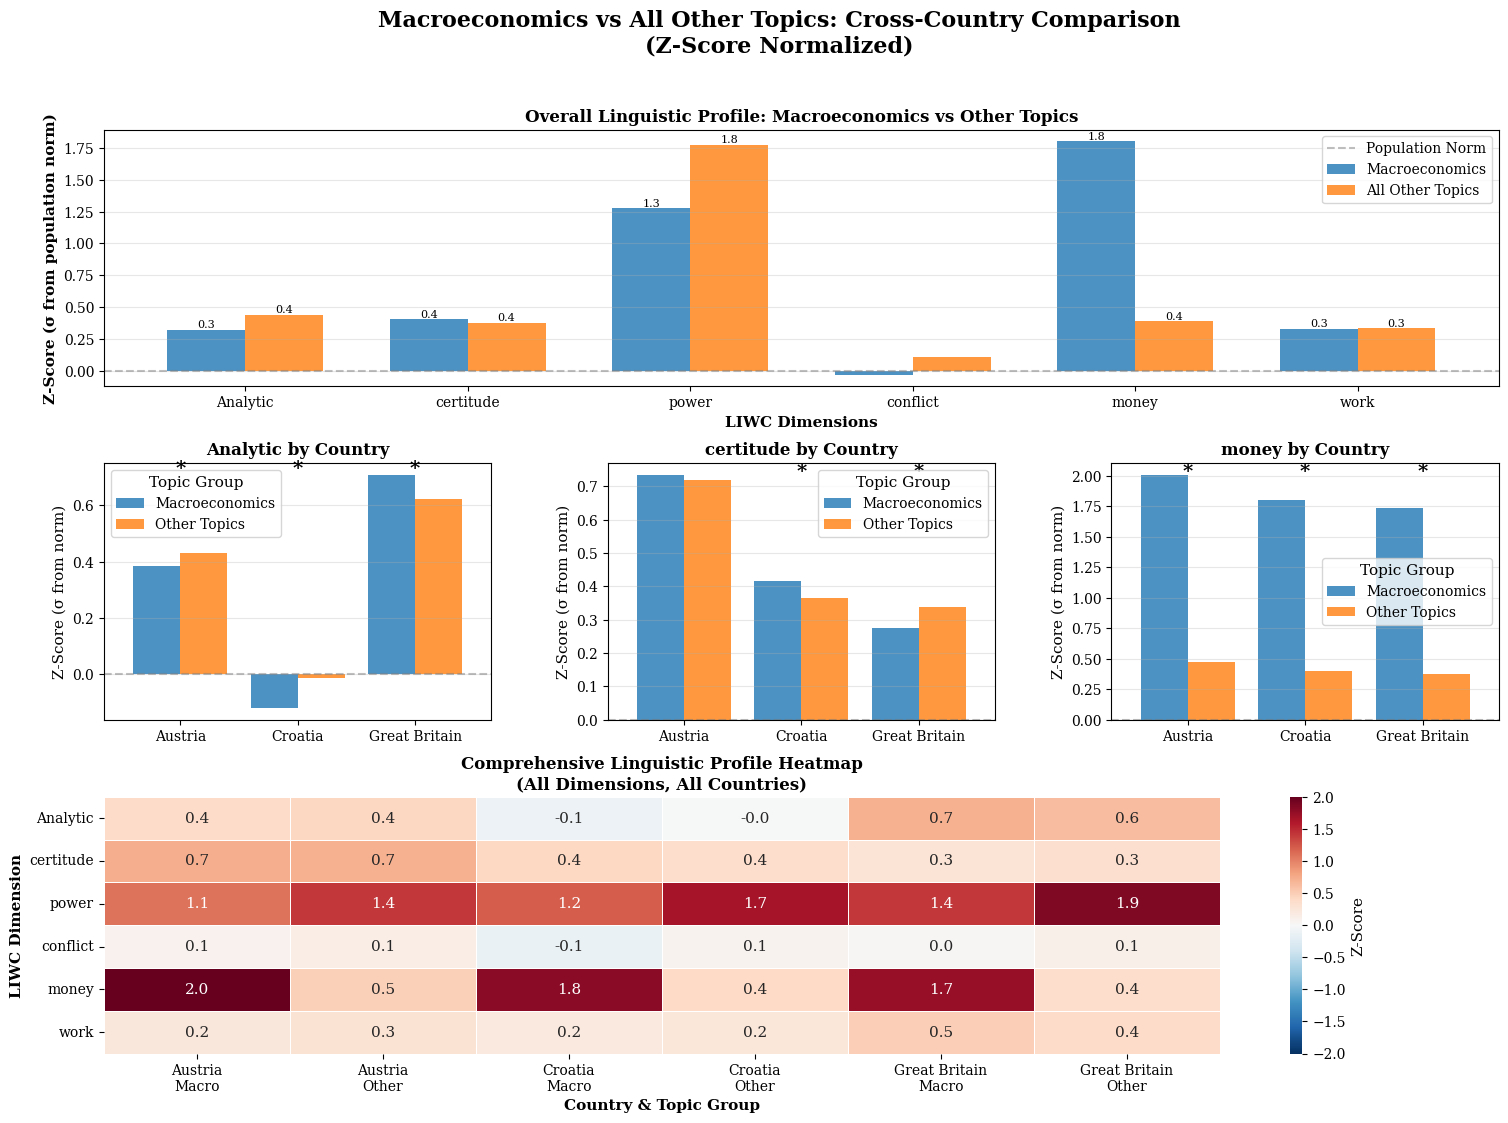


STATISTICAL COMPARISON: MACROECONOMICS vs OTHER TOPICS

ANALYTIC:
  Overall: Macro=59.14, Other=62.73, d=-0.13, p=0.000 ***
  Overall: Macro=59.14, Other=62.73, d=-0.13, p=0.000 ***
  Great Britain: Macro=70.71(n=29197), Other=68.12(n=488797), d=0.11, p=0.000 ***
  Great Britain: Macro=70.71(n=29197), Other=68.12(n=488797), d=0.11, p=0.000 ***
  Austria: Macro=61.03(n=10606), Other=62.37(n=61908), d=-0.06, p=0.000 ***
  Austria: Macro=61.03(n=10606), Other=62.37(n=61908), d=-0.06, p=0.000 ***
  Croatia: Macro=45.90(n=27053), Other=49.12(n=192051), d=-0.11, p=0.000 ***

CERTITUDE:
  Croatia: Macro=45.90(n=27053), Other=49.12(n=192051), d=-0.11, p=0.000 ***

CERTITUDE:
  Overall: Macro=0.86, Other=0.84, d=0.01, p=0.043 *
  Overall: Macro=0.86, Other=0.84, d=0.01, p=0.043 *
  Great Britain: Macro=0.78(n=29793), Other=0.82(n=495903), d=-0.02, p=0.001 **
  Great Britain: Macro=0.78(n=29793), Other=0.82(n=495903), d=-0.02, p=0.001 **
  Austria: Macro=1.05(n=10616), Other=1.04(n=62087), d=0.

In [25]:
# Macroeconomics vs All Other Topics Analysis - FOCUSED COMPARISON
if 'Our_Topic' in LIWC_ALL.columns:
    print("="*60)
    print("MACROECONOMICS vs ALL OTHER TOPICS ANALYSIS")
    print("📊 Note: Using z-scores for all comparisons due to mixed LIWC scales")
    print("="*60)
    
    # Identify macroeconomics topic
    macro_topics = [topic for topic in LIWC_ALL['Our_Topic'].unique() 
                   if 'macro' in topic.lower() or 'economy' in topic.lower() or 'economic' in topic.lower()]
    
    if len(macro_topics) == 0:
        print("⚠️ No macroeconomics topic found in dataset")
        print(f"Available topics: {', '.join(LIWC_ALL['Our_Topic'].unique()[:10])}")
    else:
        macro_topic = macro_topics[0]
        print(f"\n📊 Analyzing: '{macro_topic}' vs All Other Topics")
        
        # Create binary topic classification
        LIWC_ALL['Topic_Group'] = LIWC_ALL['Our_Topic'].apply(
            lambda x: 'Macroeconomics' if x == macro_topic else 'Other Topics'
        )
        
        # Show sample sizes
        topic_counts = LIWC_ALL.groupby(['Country', 'Topic_Group']).size().unstack(fill_value=0)
        print("\nSample sizes by country:")
        print(topic_counts)
        
        # Key analysis dimensions focusing on economic discourse
        topic_analysis_dims = [d for d in ['Analytic', 'certitude', 'power', 'conflict', 'money', 'work'] 
                              if d in LIWC_ALL.columns]
        
        # Create z-score normalized data
        benchmark_lookup = LIWC_benchmarks.set_index('Dimension')
        topic_z_data = LIWC_ALL.copy()
        
        # Normalize all analysis dimensions
        normalized_analysis_dims = []
        for dim in topic_analysis_dims:
            if dim in benchmark_lookup.index:
                benchmark_mean = benchmark_lookup.loc[dim, 'Mean']
                benchmark_std = benchmark_lookup.loc[dim, 'Std']
                topic_z_data[f'{dim}_z'] = (LIWC_ALL[dim] - benchmark_mean) / benchmark_std
                normalized_analysis_dims.append(f'{dim}_z')
        
        # Create comprehensive visualization
        fig = plt.figure(figsize=(18, 12))
        gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)
        
        fig.suptitle(f'Macroeconomics vs All Other Topics: Cross-Country Comparison\n(Z-Score Normalized)', 
                    fontsize=16, fontweight='bold')
        
        # Plot 1: Overall comparison across all dimensions (large plot)
        ax1 = fig.add_subplot(gs[0, :])
        overall_means = topic_z_data.groupby('Topic_Group')[normalized_analysis_dims].mean()
        overall_means.columns = [col.replace('_z', '') for col in overall_means.columns]
        
        x = np.arange(len(overall_means.columns))
        width = 0.35
        
        bars1 = ax1.bar(x - width/2, overall_means.loc['Macroeconomics'], width, 
                       label='Macroeconomics', alpha=0.8, color='#1f77b4')
        bars2 = ax1.bar(x + width/2, overall_means.loc['Other Topics'], width, 
                       label='All Other Topics', alpha=0.8, color='#ff7f0e')
        
        ax1.axhline(y=0, color='gray', linestyle='--', alpha=0.5, label='Population Norm')
        ax1.set_ylabel('Z-Score (σ from population norm)', fontweight='bold')
        ax1.set_xlabel('LIWC Dimensions', fontweight='bold')
        ax1.set_title('Overall Linguistic Profile: Macroeconomics vs Other Topics', fontweight='bold')
        ax1.set_xticks(x)
        ax1.set_xticklabels(overall_means.columns)
        ax1.legend(loc='best')
        ax1.grid(True, alpha=0.3, axis='y')
        
        # Add value labels on bars
        for bars in [bars1, bars2]:
            for bar in bars:
                height = bar.get_height()
                if abs(height) > 0.3:  # Only label notable differences
                    ax1.text(bar.get_x() + bar.get_width()/2., height,
                           f'{height:.1f}', ha='center', 
                           va='bottom' if height > 0 else 'top', fontsize=8)
        
        # Plots 2-4: Country-specific comparisons for key dimensions
        key_dims_for_country = ['Analytic', 'certitude', 'money']
        
        for idx, dim in enumerate(key_dims_for_country):
            dim_z = f'{dim}_z'
            if dim_z in normalized_analysis_dims:
                ax = fig.add_subplot(gs[1, idx])
                
                country_topic_means = topic_z_data.groupby(['Country', 'Topic_Group'])[dim_z].mean().unstack()
                
                country_topic_means.plot(kind='bar', ax=ax, 
                                        color=['#1f77b4', '#ff7f0e'], 
                                        width=0.8, alpha=0.8)
                ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
                ax.set_title(f'{dim} by Country', fontweight='bold')
                ax.set_ylabel('Z-Score (σ from norm)')
                ax.set_xlabel('')
                ax.tick_params(axis='x', rotation=0)
                ax.legend(title='Topic Group', loc='best')
                ax.grid(True, alpha=0.3, axis='y')
                
                # Add significance indicators
                for i, country in enumerate(country_topic_means.index):
                    country_data = topic_z_data[topic_z_data['Country'] == country]
                    macro_vals = country_data[country_data['Topic_Group'] == 'Macroeconomics'][dim].dropna()
                    other_vals = country_data[country_data['Topic_Group'] == 'Other Topics'][dim].dropna()
                    
                    if len(macro_vals) > 10 and len(other_vals) > 10:
                        _, p_val = ttest_ind(macro_vals, other_vals, equal_var=False)
                        if p_val < 0.05:
                            ax.text(i, ax.get_ylim()[1] * 0.95, '*', ha='center', 
                                   fontsize=14, fontweight='bold')
        
        # Plot 5: Heatmap of all dimensions by country and topic group
        ax5 = fig.add_subplot(gs[2, :])
        
        # Create properly formatted data for heatmap
        heatmap_data = topic_z_data.groupby(['Country', 'Topic_Group'])[normalized_analysis_dims].mean()
        heatmap_data.columns = [col.replace('_z', '') for col in heatmap_data.columns]
        
        # Create display dataframe with combined row labels
        heatmap_display = []
        row_labels = []
        
        for country in sorted(topic_z_data['Country'].unique()):
            for topic_group in ['Macroeconomics', 'Other Topics']:
                if (country, topic_group) in heatmap_data.index:
                    row_labels.append(f"{country}\n{topic_group[:5]}")
                    heatmap_display.append(heatmap_data.loc[(country, topic_group), :].values)
        
        heatmap_display = pd.DataFrame(heatmap_display, 
                                      index=row_labels, 
                                      columns=heatmap_data.columns)
        
        sns.heatmap(heatmap_display.T, annot=True, fmt='.1f', cmap='RdBu_r', center=0,
                   ax=ax5, cbar_kws={'label': 'Z-Score'}, vmin=-2, vmax=2, linewidths=0.5)
        ax5.set_title('Comprehensive Linguistic Profile Heatmap\n(All Dimensions, All Countries)', 
                     fontweight='bold')
        ax5.set_xlabel('Country & Topic Group', fontweight='bold')
        ax5.set_ylabel('LIWC Dimension', fontweight='bold')
        
        plt.tight_layout()
        plt.show()
        
        # Statistical analysis
        print("\n" + "="*60)
        print("STATISTICAL COMPARISON: MACROECONOMICS vs OTHER TOPICS")
        print("="*60)
        
        for dim in topic_analysis_dims:
            print(f"\n{dim.upper()}:")
            
            # Overall comparison
            macro_overall = LIWC_ALL[LIWC_ALL['Topic_Group'] == 'Macroeconomics'][dim].dropna()
            other_overall = LIWC_ALL[LIWC_ALL['Topic_Group'] == 'Other Topics'][dim].dropna()
            
            if len(macro_overall) > 10 and len(other_overall) > 10:
                _, p_val = ttest_ind(macro_overall, other_overall, equal_var=False)
                effect_size = (macro_overall.mean() - other_overall.mean()) / \
                             np.sqrt(((macro_overall.std()**2) + (other_overall.std()**2)) / 2)
                significance = "***" if p_val < 0.001 else "**" if p_val < 0.01 else "*" if p_val < 0.05 else ""
                
                print(f"  Overall: Macro={macro_overall.mean():.2f}, Other={other_overall.mean():.2f}, "
                      f"d={effect_size:.2f}, p={p_val:.3f} {significance}")
            
            # Country-specific comparisons
            for country in LIWC_ALL['Country'].unique():
                country_data = LIWC_ALL[LIWC_ALL['Country'] == country]
                macro_vals = country_data[country_data['Topic_Group'] == 'Macroeconomics'][dim].dropna()
                other_vals = country_data[country_data['Topic_Group'] == 'Other Topics'][dim].dropna()
                
                if len(macro_vals) > 10 and len(other_vals) > 10:
                    _, p_val = ttest_ind(macro_vals, other_vals, equal_var=False)
                    effect_size = (macro_vals.mean() - other_vals.mean()) / \
                                 np.sqrt(((macro_vals.std()**2) + (other_vals.std()**2)) / 2)
                    significance = "***" if p_val < 0.001 else "**" if p_val < 0.01 else "*" if p_val < 0.05 else ""
                    
                    print(f"  {country}: Macro={macro_vals.mean():.2f}(n={len(macro_vals)}), "
                          f"Other={other_vals.mean():.2f}(n={len(other_vals)}), "
                          f"d={effect_size:.2f}, p={p_val:.3f} {significance}")
        
        # Key findings summary
        print("\n" + "="*60)
        print("KEY FINDINGS FOR PAPER")
        print("="*60)
        
        significant_diffs = []
        for dim in topic_analysis_dims:
            macro_overall = LIWC_ALL[LIWC_ALL['Topic_Group'] == 'Macroeconomics'][dim].dropna()
            other_overall = LIWC_ALL[LIWC_ALL['Topic_Group'] == 'Other Topics'][dim].dropna()
            
            if len(macro_overall) > 10 and len(other_overall) > 10:
                _, p_val = ttest_ind(macro_overall, other_overall, equal_var=False)
                effect_size = (macro_overall.mean() - other_overall.mean()) / \
                             np.sqrt(((macro_overall.std()**2) + (other_overall.std()**2)) / 2)
                
                if p_val < 0.05:
                    significant_diffs.append({
                        'Dimension': dim,
                        'Effect_Size': effect_size,
                        'P_Value': p_val,
                        'Macro_Mean': macro_overall.mean(),
                        'Other_Mean': other_overall.mean()
                    })
        
        if significant_diffs:
            print("\nSignificant differences (sorted by effect size):")
            for diff in sorted(significant_diffs, key=lambda x: abs(x['Effect_Size']), reverse=True):
                direction = "higher" if diff['Effect_Size'] > 0 else "lower"
                print(f"• {diff['Dimension']}: Macroeconomics shows {direction} scores "
                      f"(d={abs(diff['Effect_Size']):.2f}, p={diff['P_Value']:.4f})")

else:
    print("Our_Topic column not available in dataset")

## 7. Gender Differences in Parliamentary Language

In [ ]:
# Gender analysis
if 'Speaker_gender' in LIWC_ALL.columns:
    gender_data = LIWC_ALL[LIWC_ALL['Speaker_gender'].isin(['M', 'F'])].copy()
    
    print(f"Gender Analysis:")
    print(f"Total speeches with gender data: {len(gender_data):,}")
    for country in gender_data['Country'].unique():
        country_gender = gender_data[gender_data['Country'] == country]
        male_count = len(country_gender[country_gender['Speaker_gender'] == 'M'])
        female_count = len(country_gender[country_gender['Speaker_gender'] == 'F'])
        print(f"{country}: Male={male_count:,}, Female={female_count:,}")
    
    if len(gender_data) > 100:
        # Select gender-relevant dimensions
        gender_dims = [d for d in ['Social', 'power', 'Authentic', 'Clout', 'achieve', 'family', 'Affect'] 
                      if d in gender_data.columns]
        
        fig, axes = plt.subplots(2, 2, figsize=(16, 10))
        fig.suptitle('Gender Differences in Parliamentary Language', fontsize=16, fontweight='bold')
        
        # Plot 1: Core gender dimensions by country
        for idx, dim in enumerate(gender_dims[:4]):
            ax = axes[idx//2, idx%2]
            
            gender_country_means = gender_data.groupby(['Country', 'Speaker_gender'])[dim].mean().unstack()
            
            if not gender_country_means.empty:
                gender_country_means.plot(kind='bar', ax=ax, color=['#ff69b4', '#4169e1'], 
                                        width=0.8, alpha=0.8)
                ax.set_title(f'{dim} by Country and Gender', fontweight='bold')
                ax.set_ylabel(f'Mean {dim}')
                ax.set_xlabel('Country')
                ax.legend(title='Gender', labels=['Female', 'Male'])
                ax.tick_params(axis='x', rotation=0)
                ax.grid(True, alpha=0.3)
                
                # Add significance testing
                for i, country in enumerate(gender_country_means.index):
                    country_gender_subset = gender_data[gender_data['Country'] == country]
                    male_vals = country_gender_subset[country_gender_subset['Speaker_gender'] == 'M'][dim].dropna()
                    female_vals = country_gender_subset[country_gender_subset['Speaker_gender'] == 'F'][dim].dropna()
                    
                    if len(male_vals) > 10 and len(female_vals) > 10:
                        _, p_val = ttest_ind(male_vals, female_vals, equal_var=False)
                        if p_val < 0.05:
                            ax.text(i, ax.get_ylim()[1] * 0.95, '*', ha='center', fontsize=12, fontweight='bold')
        
        plt.tight_layout()
        plt.show()
        
        # Additional gender analysis: Interaction with political orientation
        if 'Party_orientation' in gender_data.columns:
            fig, axes = plt.subplots(1, 2, figsize=(14, 6))
            fig.suptitle('Gender × Political Orientation Interactions', fontsize=14, fontweight='bold')
            
            # Power language by gender and orientation
            if 'power' in gender_data.columns:
                power_interaction = gender_data.groupby(['Party_orientation', 'Speaker_gender'])['power'].mean().unstack()
                
                ax = axes[0]
                if not power_interaction.empty:
                    power_interaction.plot(kind='bar', ax=ax, color=['#ff69b4', '#4169e1'], alpha=0.8)
                    ax.set_title('Power Language by Orientation & Gender', fontweight='bold')
                    ax.set_ylabel('Mean Power Score')
                    ax.set_xlabel('Political Orientation')
                    ax.legend(title='Gender', labels=['Female', 'Male'])
                    ax.tick_params(axis='x', rotation=45)
                    ax.grid(True, alpha=0.3)
            
            # Social language by gender and orientation
            if 'Social' in gender_data.columns:
                social_interaction = gender_data.groupby(['Party_orientation', 'Speaker_gender'])['Social'].mean().unstack()
                
                ax = axes[1]
                if not social_interaction.empty:
                    social_interaction.plot(kind='bar', ax=ax, color=['#ff69b4', '#4169e1'], alpha=0.8)
                    ax.set_title('Social Language by Orientation & Gender', fontweight='bold')
                    ax.set_ylabel('Mean Social Score')
                    ax.set_xlabel('Political Orientation')
                    ax.legend(title='Gender', labels=['Female', 'Male'])
                    ax.tick_params(axis='x', rotation=45)
                    ax.grid(True, alpha=0.3)
            
            plt.tight_layout()
            plt.show()
        
        # Gender statistics summary
        print("\n" + "="*60)
        print("GENDER DIFFERENCES BY COUNTRY")
        print("="*60)
        
        for dim in gender_dims:
            print(f"\n{dim}:")
            for country in gender_data['Country'].unique():
                country_gender_subset = gender_data[gender_data['Country'] == country]
                male_vals = country_gender_subset[country_gender_subset['Speaker_gender'] == 'M'][dim].dropna()
                female_vals = country_gender_subset[country_gender_subset['Speaker_gender'] == 'F'][dim].dropna()
                
                if len(male_vals) > 5 and len(female_vals) > 5:
                    stat, p_val = ttest_ind(male_vals, female_vals, equal_var=False)
                    effect_size = (male_vals.mean() - female_vals.mean()) / np.sqrt(((male_vals.std()**2) + (female_vals.std()**2)) / 2)
                    significance = "*" if p_val < 0.05 else ""
                    print(f"  {country}: M={male_vals.mean():.2f}(n={len(male_vals)}), F={female_vals.mean():.2f}(n={len(female_vals)}), d={effect_size:.2f}, p={p_val:.3f} {significance}")
    else:
        print("Insufficient gender data for analysis")
else:
    print("Speaker_gender column not available in dataset")

In [ ]:
# Summary Statistics for Paper
print("\n" + "="*60)
print("KEY DATASET STATISTICS FOR PAPER")
print("="*60)
print(f"Total speeches analyzed: {len(LIWC_ALL):,}")
print(f"Countries: {', '.join(LIWC_ALL['Country'].unique())}")
print(f"Unique speakers: {LIWC_ALL['Speaker_ID'].nunique():,}")
print(f"Topics: {len(LIWC_ALL['Our_Topic'].unique())}")

if 'Year' in LIWC_ALL.columns and LIWC_ALL['Year'].notna().sum() > 0:
    year_min = int(LIWC_ALL['Year'].min())
    year_max = int(LIWC_ALL['Year'].max())
    print(f"Time span: {year_min}-{year_max}")

print(f"\nLIWC Dimensions analyzed: {len(KEY_LIWC_DIMENSIONS)}")
print(f"Figures saved to: {output_dir}")


KEY DATASET STATISTICS FOR PAPER
Total speeches analyzed: 892,238
Countries: Great Britain, Austria, Croatia
Unique speakers: 3,796
Unique speakers: 3,796
Topics: 21
Time span: 1996-2022

LIWC Dimensions analyzed: 23
Figures saved to: C:\Users\pavle\OneDrive\Desktop\my github\master-thesis\figures
Topics: 21
Time span: 1996-2022

LIWC Dimensions analyzed: 23
Figures saved to: C:\Users\pavle\OneDrive\Desktop\my github\master-thesis\figures
